In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [55]:
# ============================================================================
# POST-ANALYSIS & OPERATIONAL INSIGHTS NOTEBOOK
# Deliverable 3: Deep-dive into difficult destinations and actionable recommendations
# ============================================================================

# Load Pre-Computed Results
# This assumes the main analysis notebook have been run and saved the results
# Load the master dataset with difficulty scores
master_data = pd.read_csv('team_sarthak.csv')

flight_data = pd.read_csv('Dataset/Flight_Level_Data.csv')
pnr_flight_data = pd.read_csv('Dataset/PNR_Flight_Level_Data.csv')
pnr_remarks_data = pd.read_csv('Dataset/PNR_Remark_Level_Data.csv')
airports_data = pd.read_csv('Dataset/Airports_Data.csv')
bag_data = pd.read_csv('Dataset/Bag_Level_Data.csv')

print(f"Master data loaded: {master_data.shape[0]:,} flights")
print(f"Unique destinations: {master_data['scheduled_arrival_station_code'].nunique()}")
print(f"Date range: {master_data['scheduled_departure_date_local'].min()} to {master_data['scheduled_departure_date_local'].max()}")

# Convert date columns
master_data['scheduled_departure_date_local'] = pd.to_datetime(
    master_data['scheduled_departure_date_local']
)

print("\nData loaded successfully!\n")

# Quick Data Overview
print("="*80)
print("DATA OVERVIEW")
print("="*80)

print("\nDifficulty Category Distribution:")
print(master_data['difficulty_category'].value_counts())
print(f"\nPercentage distribution:")
print(master_data['difficulty_category'].value_counts(normalize=True) * 100)

print(f"\nDifficulty Score Statistics:")
print(master_data['difficulty_score_scaled'].describe())

print("\nTop 10 Destinations by Flight Volume:")
print(master_data['scheduled_arrival_station_code'].value_counts().head(10))

Master data loaded: 8,099 flights
Unique destinations: 188
Date range: 2025-08-01 to 2025-08-15

Data loaded successfully!

DATA OVERVIEW

Difficulty Category Distribution:
difficulty_category
Easy         3234
Medium       2829
Difficult    2036
Name: count, dtype: int64

Percentage distribution:
difficulty_category
Easy         39.930856
Medium       34.930238
Difficult    25.138906
Name: proportion, dtype: float64

Difficulty Score Statistics:
count    8099.000000
mean       41.547467
std        11.811441
min         0.000000
25%        33.406272
50%        41.188432
75%        48.069072
max       100.000000
Name: difficulty_score_scaled, dtype: float64

Top 10 Destinations by Flight Volume:
scheduled_arrival_station_code
LGA    188
IAH    160
LAX    155
SFO    155
DCA    153
DEN    148
EWR    148
BOS    121
STL    117
IND    104
Name: count, dtype: int64


In [28]:
# Identify Consistently Difficult Destinations
print("\n" + "="*80)
print("ANALYSIS 1: CONSISTENTLY DIFFICULT DESTINATIONS")
print("="*80)

# Calculate metrics per destination
destination_metrics = master_data.groupby('scheduled_arrival_station_code').agg({
    'difficulty_score_scaled': ['mean', 'median', 'std', 'min', 'max'],
    'flight_id': 'count',
    'difficulty_category': lambda x: (x == 'Difficult').sum(),
    'departure_delay_minutes': 'mean',
    'load_factor': 'mean',
    'ground_time_pressure': 'mean',
    'bags_per_passenger': 'mean',
    'transfer_ratio': 'mean',
    'special_service_ratio': 'mean',
    'wheelchair_ratio': 'mean',
    'is_tight_turnaround': 'sum',
    'is_international': 'max'
}).round(3)

# Flatten column names
destination_metrics.columns = [
    'avg_difficulty', 'median_difficulty', 'std_difficulty', 'min_difficulty', 'max_difficulty',
    'total_flights', 'difficult_flight_count', 'avg_delay',
    'avg_load_factor', 'avg_ground_pressure', 'avg_bags_per_pax',
    'avg_transfer_ratio', 'avg_ssr_ratio', 'avg_wheelchair_ratio',
    'tight_turnaround_count', 'is_international'
]

# Calculate percentage of difficult flights
destination_metrics['pct_difficult'] = (
    destination_metrics['difficult_flight_count'] / destination_metrics['total_flights'] * 100
).round(1)

# Calculate consistency score (lower std = more consistent difficulty)
destination_metrics['consistency_score'] = (
    destination_metrics['avg_difficulty'] / (destination_metrics['std_difficulty'] + 0.1)
).round(2)

# Filter for destinations with at least 5 flights (statistical significance)
significant_destinations = destination_metrics[destination_metrics['total_flights'] >= 5].copy()

print(f"\nAnalyzing {len(significant_destinations)} destinations with ≥5 flights")
print(f"(Excluded {len(destination_metrics) - len(significant_destinations)} destinations with <5 flights)")

# Rank Destinations by Multiple Criteria
print("\n" + "-"*80)
print("RANKING METHODOLOGY")
print("-"*80)

# Create composite ranking scores
significant_destinations['composite_rank_score'] = (
    significant_destinations['avg_difficulty'] * 0.40 +  # 40% weight on average difficulty
    significant_destinations['pct_difficult'] * 0.30 +   # 30% weight on % difficult flights
    significant_destinations['consistency_score'] * 0.15 + # 15% weight on consistency
    significant_destinations['avg_delay'] * 0.15         # 15% weight on delays
)

# Sort by composite score
significant_destinations = significant_destinations.sort_values(
    'composite_rank_score', ascending=False
)

print("\nRanking based on:")
print("  • 40% - Average Difficulty Score")
print("  • 30% - Percentage of Difficult Flights")
print("  • 15% - Consistency of Difficulty")
print("  • 15% - Average Departure Delay")


ANALYSIS 1: CONSISTENTLY DIFFICULT DESTINATIONS

Analyzing 171 destinations with ≥5 flights
(Excluded 17 destinations with <5 flights)

--------------------------------------------------------------------------------
RANKING METHODOLOGY
--------------------------------------------------------------------------------

Ranking based on:
  • 40% - Average Difficulty Score
  • 30% - Percentage of Difficult Flights
  • 15% - Consistency of Difficulty
  • 15% - Average Departure Delay


In [26]:
# Identify Top Consistently Difficult Destinations
TOP_N = 15

print("\n" + "="*80)
print(f"TOP {TOP_N} CONSISTENTLY DIFFICULT DESTINATIONS")
print("="*80)

top_difficult_destinations = significant_destinations.head(TOP_N)

# Create detailed report
report_cols = [
    'total_flights', 'avg_difficulty', 'pct_difficult', 
    'avg_delay', 'avg_load_factor', 'avg_ground_pressure',
    'tight_turnaround_count', 'is_international'
]

print("\n", top_difficult_destinations[report_cols].to_string())

# Export to CSV
top_difficult_destinations.to_csv('top_difficult_destinations.csv')
print("\n✓ Exported to 'top_difficult_destinations.csv'")


TOP 15 CONSISTENTLY DIFFICULT DESTINATIONS

                                 total_flights  avg_difficulty  pct_difficult  avg_delay  avg_load_factor  avg_ground_pressure  tight_turnaround_count  is_international
scheduled_arrival_station_code                                                                                                                                         
BRU                                        15          83.616          100.0     42.667            0.993                4.254                       5                 1
GRU                                        15          68.750          100.0     67.933            0.959                2.314                       0                 1
CDG                                        15          69.729          100.0     54.667            0.952                2.794                       3                 1
FRA                                        30          70.612          100.0     52.567            0.956          

In [30]:
# Categorize Destinations by Difficulty Profile
print("\n" + "="*80)
print("DESTINATION CATEGORIZATION BY DIFFICULTY PROFILE")
print("="*80)

def categorize_destination(row):
    """Categorize destination based on difficulty characteristics"""
    if row['pct_difficult'] >= 40:
        return 'Chronically Difficult'
    elif row['pct_difficult'] >= 25:
        return 'Moderately Difficult'
    elif row['avg_difficulty'] >= 60:
        return 'Sporadically Difficult'
    else:
        return 'Generally Manageable'

significant_destinations['difficulty_profile'] = significant_destinations.apply(
    categorize_destination, axis=1
)

profile_summary = significant_destinations['difficulty_profile'].value_counts()
print("\nDestination Profiles:")
for profile, count in profile_summary.items():
    pct = count / len(significant_destinations) * 100
    print(f"  {profile}: {count} destinations ({pct:.1f}%)")

# Focus on chronically and moderately difficult
problem_destinations = significant_destinations[
    significant_destinations['difficulty_profile'].isin(['Chronically Difficult', 'Moderately Difficult'])
]

print(f"\n⚠ {len(problem_destinations)} destinations require immediate attention")
print("\nProblem Destinations:")
print(problem_destinations[['total_flights', 'avg_difficulty', 'pct_difficult', 'difficulty_profile']].to_string())


DESTINATION CATEGORIZATION BY DIFFICULTY PROFILE

Destination Profiles:
  Generally Manageable: 106 destinations (62.0%)
  Chronically Difficult: 48 destinations (28.1%)
  Moderately Difficult: 17 destinations (9.9%)

⚠ 65 destinations require immediate attention

Problem Destinations:
                                total_flights  avg_difficulty  pct_difficult     difficulty_profile
scheduled_arrival_station_code                                                                     
BRU                                        15          83.616          100.0  Chronically Difficult
GRU                                        15          68.750          100.0  Chronically Difficult
CDG                                        15          69.729          100.0  Chronically Difficult
FRA                                        30          70.612          100.0  Chronically Difficult
EDI                                        15          64.085          100.0  Chronically Difficult
DUB         

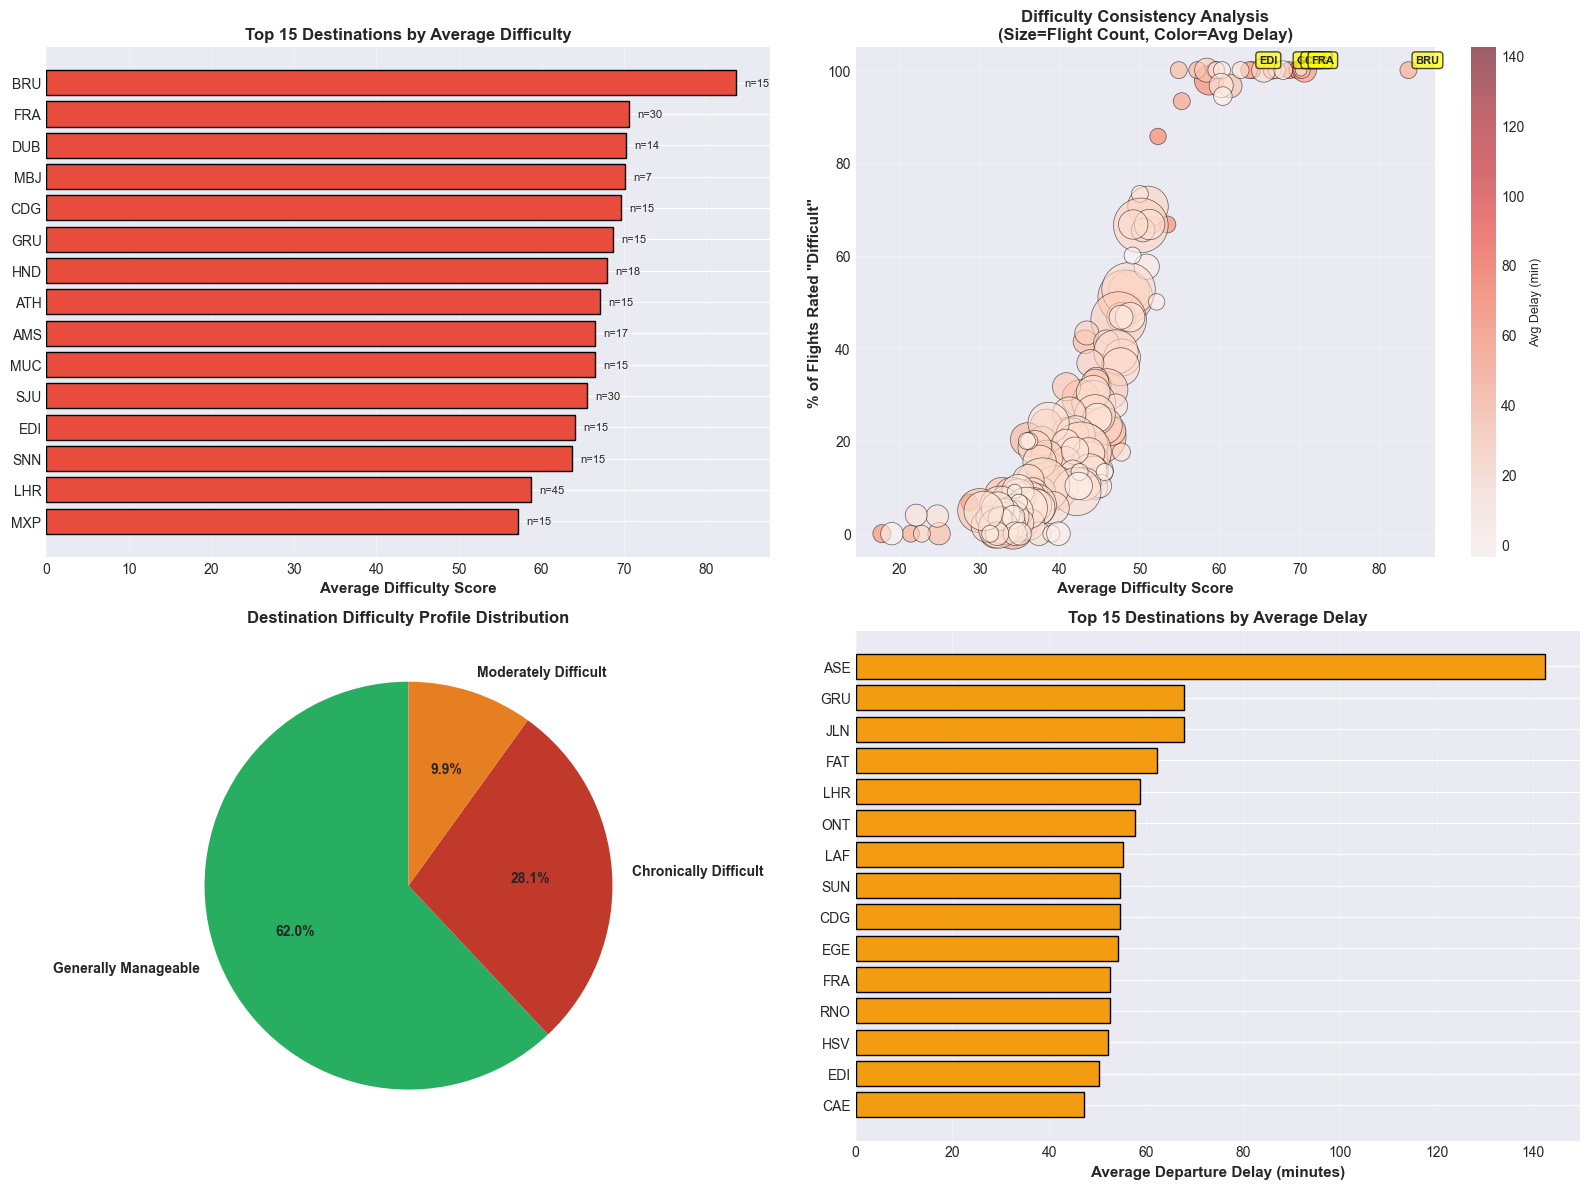


✓ Visualization saved as 'difficult_destinations_analysis.png'


In [31]:
# Visualizing Top Difficult Destinations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 15 by average difficulty
top_15 = top_difficult_destinations.head(15).sort_values('avg_difficulty')
axes[0, 0].barh(range(len(top_15)), top_15['avg_difficulty'], color='#e74c3c', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels(top_15.index)
axes[0, 0].set_xlabel('Average Difficulty Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 Destinations by Average Difficulty', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Add flight count annotations
for i, (idx, row) in enumerate(top_15.iterrows()):
    axes[0, 0].text(row['avg_difficulty'] + 1, i, f"n={int(row['total_flights'])}", 
                    va='center', fontsize=8)

# 2. Difficulty vs % Difficult Flights scatter
axes[0, 1].scatter(significant_destinations['avg_difficulty'], 
                   significant_destinations['pct_difficult'],
                   s=significant_destinations['total_flights']*10,
                   alpha=0.6, c=significant_destinations['avg_delay'],
                   cmap='Reds', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Average Difficulty Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('% of Flights Rated "Difficult"', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Difficulty Consistency Analysis\n(Size=Flight Count, Color=Avg Delay)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Avg Delay (min)', fontsize=9)

# Annotate top 5
for idx, row in top_difficult_destinations.head(5).iterrows():
    axes[0, 1].annotate(idx, 
                        xy=(row['avg_difficulty'], row['pct_difficult']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 3. Destination profile distribution
profile_counts = significant_destinations['difficulty_profile'].value_counts()
colors_profile = {'Chronically Difficult': '#c0392b', 
                  'Moderately Difficult': '#e67e22',
                  'Sporadically Difficult': '#f39c12',
                  'Generally Manageable': '#27ae60'}
axes[1, 0].pie(profile_counts.values, labels=profile_counts.index,
               colors=[colors_profile.get(x, 'gray') for x in profile_counts.index],
               autopct='%1.1f%%', startangle=90,
               textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1, 0].set_title('Destination Difficulty Profile Distribution', 
                     fontsize=12, fontweight='bold')

# 4. Top destinations by delay
top_delay = significant_destinations.nlargest(15, 'avg_delay').sort_values('avg_delay')
axes[1, 1].barh(range(len(top_delay)), top_delay['avg_delay'], 
                color='#f39c12', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_delay)))
axes[1, 1].set_yticklabels(top_delay.index)
axes[1, 1].set_xlabel('Average Departure Delay (minutes)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 15 Destinations by Average Delay', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('difficult_destinations_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'difficult_destinations_analysis.png'")


ANALYSIS 2: PRIMARY DIFFICULTY DRIVERS BY DESTINATION

Primary Drivers for Top 10 Difficult Destinations:
--------------------------------------------------------------------------------

BRU:
  Avg Difficulty: 83.6
  Flights: 15
  Top 3 Drivers:
    1. International Flight: Extremely Higher (z=9.08)
    2. Tight Turnaround %: Extremely Higher (z=2.37)
    3. Heavy Baggage: Extremely Higher (z=2.10)

GRU:
  Avg Difficulty: 68.8
  Flights: 15
  Top 3 Drivers:
    1. International Flight: Extremely Higher (z=9.08)
    2. Heavy Baggage: Extremely Higher (z=2.12)
    3. Tight Turnaround %: Moderately Lower (z=-0.96)

CDG:
  Avg Difficulty: 69.7
  Flights: 15
  Top 3 Drivers:
    1. International Flight: Extremely Higher (z=9.08)
    2. Tight Turnaround %: Significantly Higher (z=1.04)
    3. High Transfer Bags: Slightly Lower (z=-0.45)

FRA:
  Avg Difficulty: 70.6
  Flights: 30
  Top 3 Drivers:
    1. International Flight: Extremely Higher (z=9.08)
    2. Heavy Baggage: Moderately Higher 

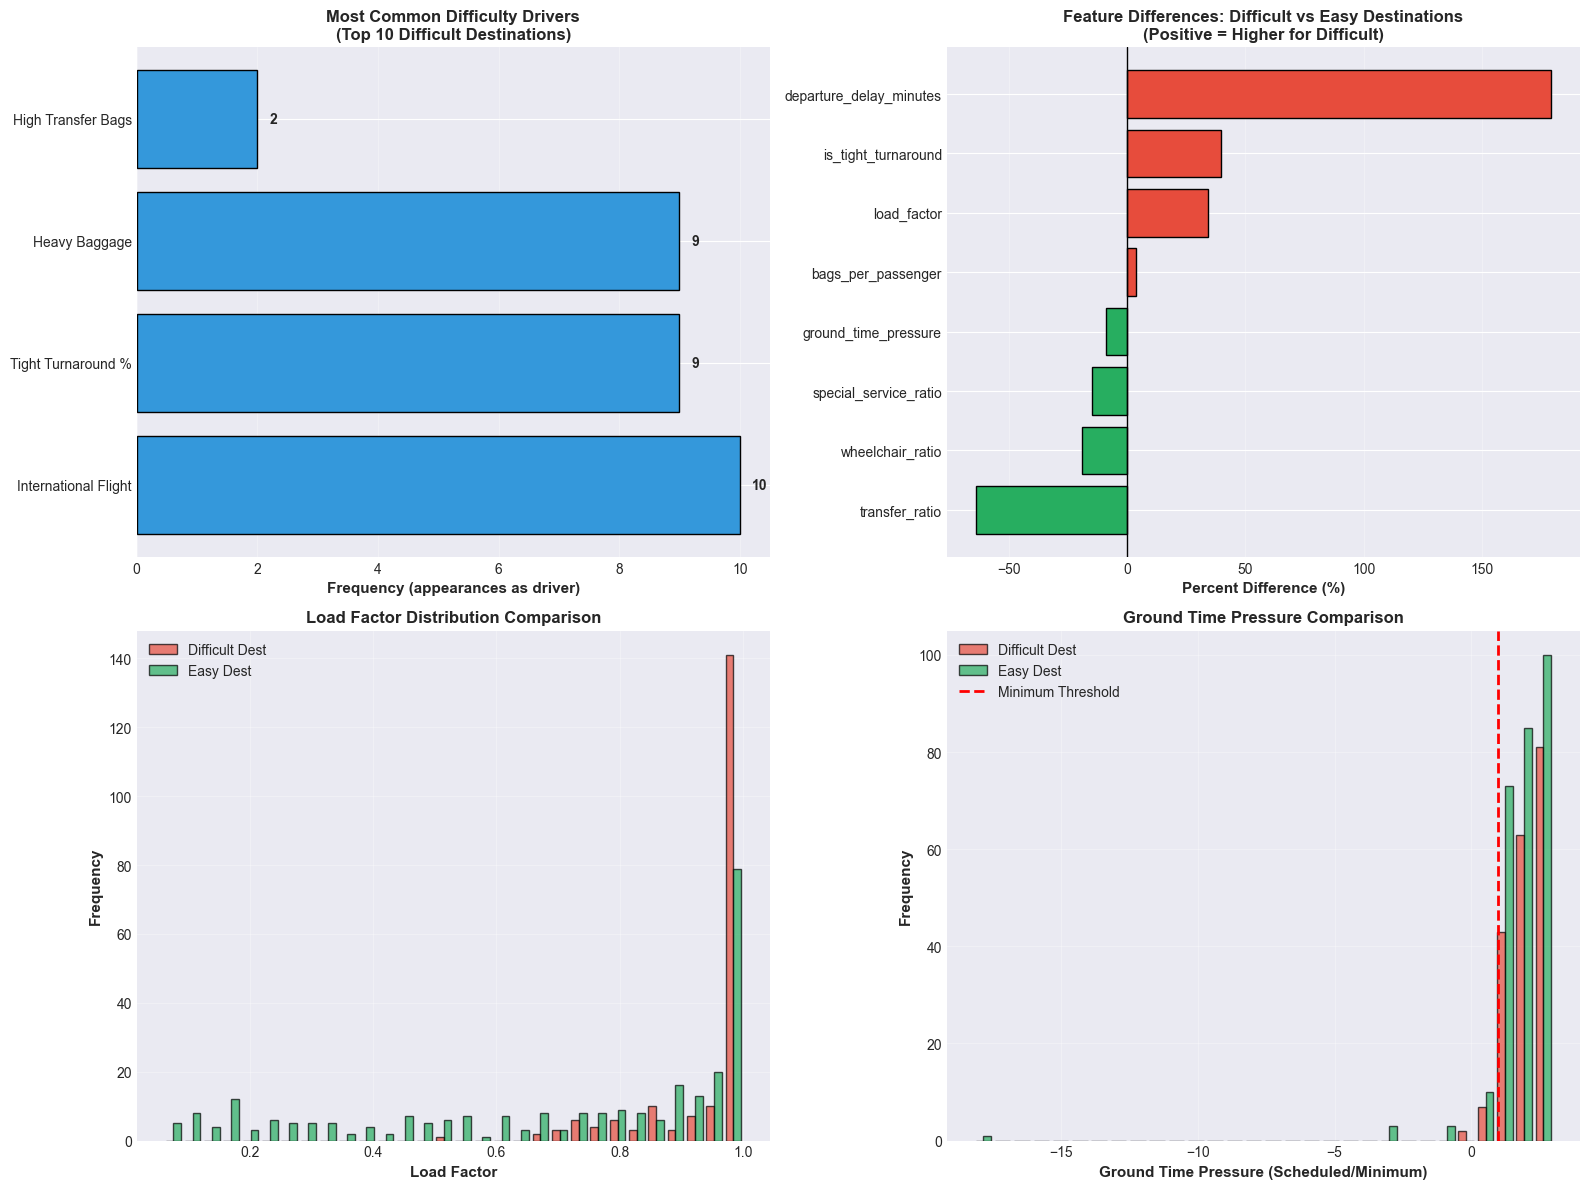


✓ Visualization saved as 'driver_patterns_analysis.png'


In [4]:
# Analyze Primary Difficulty Drivers for Each Destination
print("\n" + "="*80)
print("ANALYSIS 2: PRIMARY DIFFICULTY DRIVERS BY DESTINATION")
print("="*80)

# Define driver categories and their features
driver_features = {
    'Ground Time Pressure': ['ground_time_pressure', 'is_tight_turnaround'],
    'High Passenger Load': ['load_factor'],
    'Baggage Complexity': ['bags_per_passenger', 'transfer_ratio'],
    'Special Service Needs': ['special_service_ratio', 'wheelchair_ratio'],
    'Flight Characteristics': ['is_international', 'haul_type']
}

# For each top difficult destination, identify primary drivers
def identify_primary_drivers(destination_code, data, top_n=3):
    """Identify top N contributing factors for a destination's difficulty"""
    
    dest_flights = data[data['scheduled_arrival_station_code'] == destination_code]
    all_flights = data
    
    # Calculate z-scores for key features (how much above average)
    driver_scores = {}
    
    # Ground time pressure (lower is worse, so invert)
    if 'ground_time_pressure' in dest_flights.columns:
        dest_avg = dest_flights['ground_time_pressure'].mean()
        all_avg = all_flights['ground_time_pressure'].mean()
        all_std = all_flights['ground_time_pressure'].std()
        driver_scores['Tight Turnaround Time'] = -((dest_avg - all_avg) / (all_std + 0.01))
    
    # Load factor
    if 'load_factor' in dest_flights.columns:
        dest_avg = dest_flights['load_factor'].mean()
        all_avg = all_flights['load_factor'].mean()
        all_std = all_flights['load_factor'].std()
        driver_scores['High Passenger Load'] = (dest_avg - all_avg) / (all_std + 0.01)
    
    # Bags per passenger
    if 'bags_per_passenger' in dest_flights.columns:
        dest_avg = dest_flights['bags_per_passenger'].mean()
        all_avg = all_flights['bags_per_passenger'].mean()
        all_std = all_flights['bags_per_passenger'].std()
        driver_scores['Heavy Baggage'] = (dest_avg - all_avg) / (all_std + 0.01)
    
    # Transfer ratio
    if 'transfer_ratio' in dest_flights.columns:
        dest_avg = dest_flights['transfer_ratio'].mean()
        all_avg = all_flights['transfer_ratio'].mean()
        all_std = all_flights['transfer_ratio'].std()
        driver_scores['High Transfer Bags'] = (dest_avg - all_avg) / (all_std + 0.01)
    
    # Special service ratio
    if 'special_service_ratio' in dest_flights.columns:
        dest_avg = dest_flights['special_service_ratio'].mean()
        all_avg = all_flights['special_service_ratio'].mean()
        all_std = all_flights['special_service_ratio'].std()
        driver_scores['Special Service Requests'] = (dest_avg - all_avg) / (all_std + 0.01)
    
    # Wheelchair ratio
    if 'wheelchair_ratio' in dest_flights.columns:
        dest_avg = dest_flights['wheelchair_ratio'].mean()
        all_avg = all_flights['wheelchair_ratio'].mean()
        all_std = all_flights['wheelchair_ratio'].std()
        driver_scores['Wheelchair Assistance'] = (dest_avg - all_avg) / (all_std + 0.01)
    
    # Tight turnaround percentage
    if 'is_tight_turnaround' in dest_flights.columns:
        dest_pct = (dest_flights['is_tight_turnaround'].sum() / len(dest_flights)) * 100
        all_pct = (all_flights['is_tight_turnaround'].sum() / len(all_flights)) * 100
        driver_scores['Tight Turnaround %'] = (dest_pct - all_pct) / 10  # Normalize
    
    # International percentage
    if 'is_international' in dest_flights.columns:
        dest_pct = (dest_flights['is_international'].sum() / len(dest_flights)) * 100
        all_pct = (all_flights['is_international'].sum() / len(all_flights)) * 100
        driver_scores['International Flight'] = (dest_pct - all_pct) / 10  # Normalize
    
    # Sort by absolute impact
    sorted_drivers = sorted(driver_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    
    return sorted_drivers[:top_n]

# Analyze top 10 difficult destinations
print("\nPrimary Drivers for Top 10 Difficult Destinations:")
print("-"*80)

driver_analysis_results = []

for destination in top_difficult_destinations.head(10).index:
    drivers = identify_primary_drivers(destination, master_data, top_n=3)
    
    print(f"\n{destination}:")
    print(f"  Avg Difficulty: {top_difficult_destinations.loc[destination, 'avg_difficulty']:.1f}")
    print(f"  Flights: {int(top_difficult_destinations.loc[destination, 'total_flights'])}")
    print(f"  Top 3 Drivers:")
    
    driver_list = []
    for i, (driver, score) in enumerate(drivers, 1):
        impact = "Higher" if score > 0 else "Lower"
        magnitude = abs(score)
        if magnitude > 2:
            strength = "Extremely"
        elif magnitude > 1:
            strength = "Significantly"
        elif magnitude > 0.5:
            strength = "Moderately"
        else:
            strength = "Slightly"
        
        print(f"    {i}. {driver}: {strength} {impact} (z={score:.2f})")
        driver_list.append(driver)
    
    driver_analysis_results.append({
        'Destination': destination,
        'Primary_Driver': drivers[0][0] if drivers else 'Unknown',
        'Secondary_Driver': drivers[1][0] if len(drivers) > 1 else 'Unknown',
        'Tertiary_Driver': drivers[2][0] if len(drivers) > 2 else 'Unknown',
        'Primary_Impact': drivers[0][1] if drivers else 0,
        'Flights': int(top_difficult_destinations.loc[destination, 'total_flights']),
        'Avg_Difficulty': top_difficult_destinations.loc[destination, 'avg_difficulty']
    })

# Create driver analysis dataframe
driver_analysis_df = pd.DataFrame(driver_analysis_results)
driver_analysis_df.to_csv('destination_driver_analysis.csv', index=False)
print("\n✓ Exported to 'destination_driver_analysis.csv'")

In [33]:
# Aggregate Driver Patterns Across All Difficult Destinations
print("\n" + "="*80)
print("AGGREGATE DRIVER PATTERNS")
print("="*80)

# Count frequency of each driver appearing as primary
all_drivers = []
for result in driver_analysis_results:
    all_drivers.extend([result['Primary_Driver'], result['Secondary_Driver'], result['Tertiary_Driver']])

driver_frequency = Counter(all_drivers)
driver_frequency.pop('Unknown', None)  # Remove unknown

print("\nMost Common Difficulty Drivers (across top 10 destinations):")
for driver, count in driver_frequency.most_common():
    pct = (count / (len(driver_analysis_results) * 3)) * 100
    print(f"  {driver}: {count} occurrences ({pct:.1f}%)")


AGGREGATE DRIVER PATTERNS

Most Common Difficulty Drivers (across top 10 destinations):
  International Flight: 10 occurrences (33.3%)
  Tight Turnaround %: 9 occurrences (30.0%)
  Heavy Baggage: 9 occurrences (30.0%)
  High Transfer Bags: 2 occurrences (6.7%)


In [34]:
# Deep Dive - Feature Comparison for Difficult vs Easy Destinations
print("\n" + "="*80)
print("FEATURE COMPARISON: DIFFICULT vs EASY DESTINATIONS")
print("="*80)

# Get top 10 difficult and bottom 10 easy destinations
difficult_dest = top_difficult_destinations.head(10).index.tolist()
easy_dest = significant_destinations.tail(10).index.tolist()

# Get all flights for these destinations
difficult_flights = master_data[master_data['scheduled_arrival_station_code'].isin(difficult_dest)]
easy_flights = master_data[master_data['scheduled_arrival_station_code'].isin(easy_dest)]

# Compare key features
comparison_features = [
    'ground_time_pressure', 'is_tight_turnaround', 'load_factor',
    'bags_per_passenger', 'transfer_ratio', 'special_service_ratio',
    'wheelchair_ratio', 'departure_delay_minutes'
]

comparison_results = []
for feature in comparison_features:
    if feature in master_data.columns:
        difficult_mean = difficult_flights[feature].mean()
        easy_mean = easy_flights[feature].mean()
        difference = difficult_mean - easy_mean
        pct_diff = (difference / (easy_mean + 0.001)) * 100
        
        comparison_results.append({
            'Feature': feature,
            'Difficult_Avg': difficult_mean,
            'Easy_Avg': easy_mean,
            'Absolute_Diff': difference,
            'Percent_Diff': pct_diff
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.round(3)

print("\n", comparison_df.to_string(index=False))


FEATURE COMPARISON: DIFFICULT vs EASY DESTINATIONS

                 Feature  Difficult_Avg  Easy_Avg  Absolute_Diff  Percent_Diff
   ground_time_pressure          4.237     4.646         -0.409        -8.805
    is_tight_turnaround          0.102     0.073          0.029        39.759
            load_factor          0.953     0.709          0.244        34.373
     bags_per_passenger          0.832     0.801          0.031         3.837
         transfer_ratio          1.379     3.821         -2.442       -63.893
  special_service_ratio          0.022     0.026         -0.004       -14.698
       wheelchair_ratio          0.021     0.026         -0.005       -18.952
departure_delay_minutes         47.959    17.189         30.770       178.999


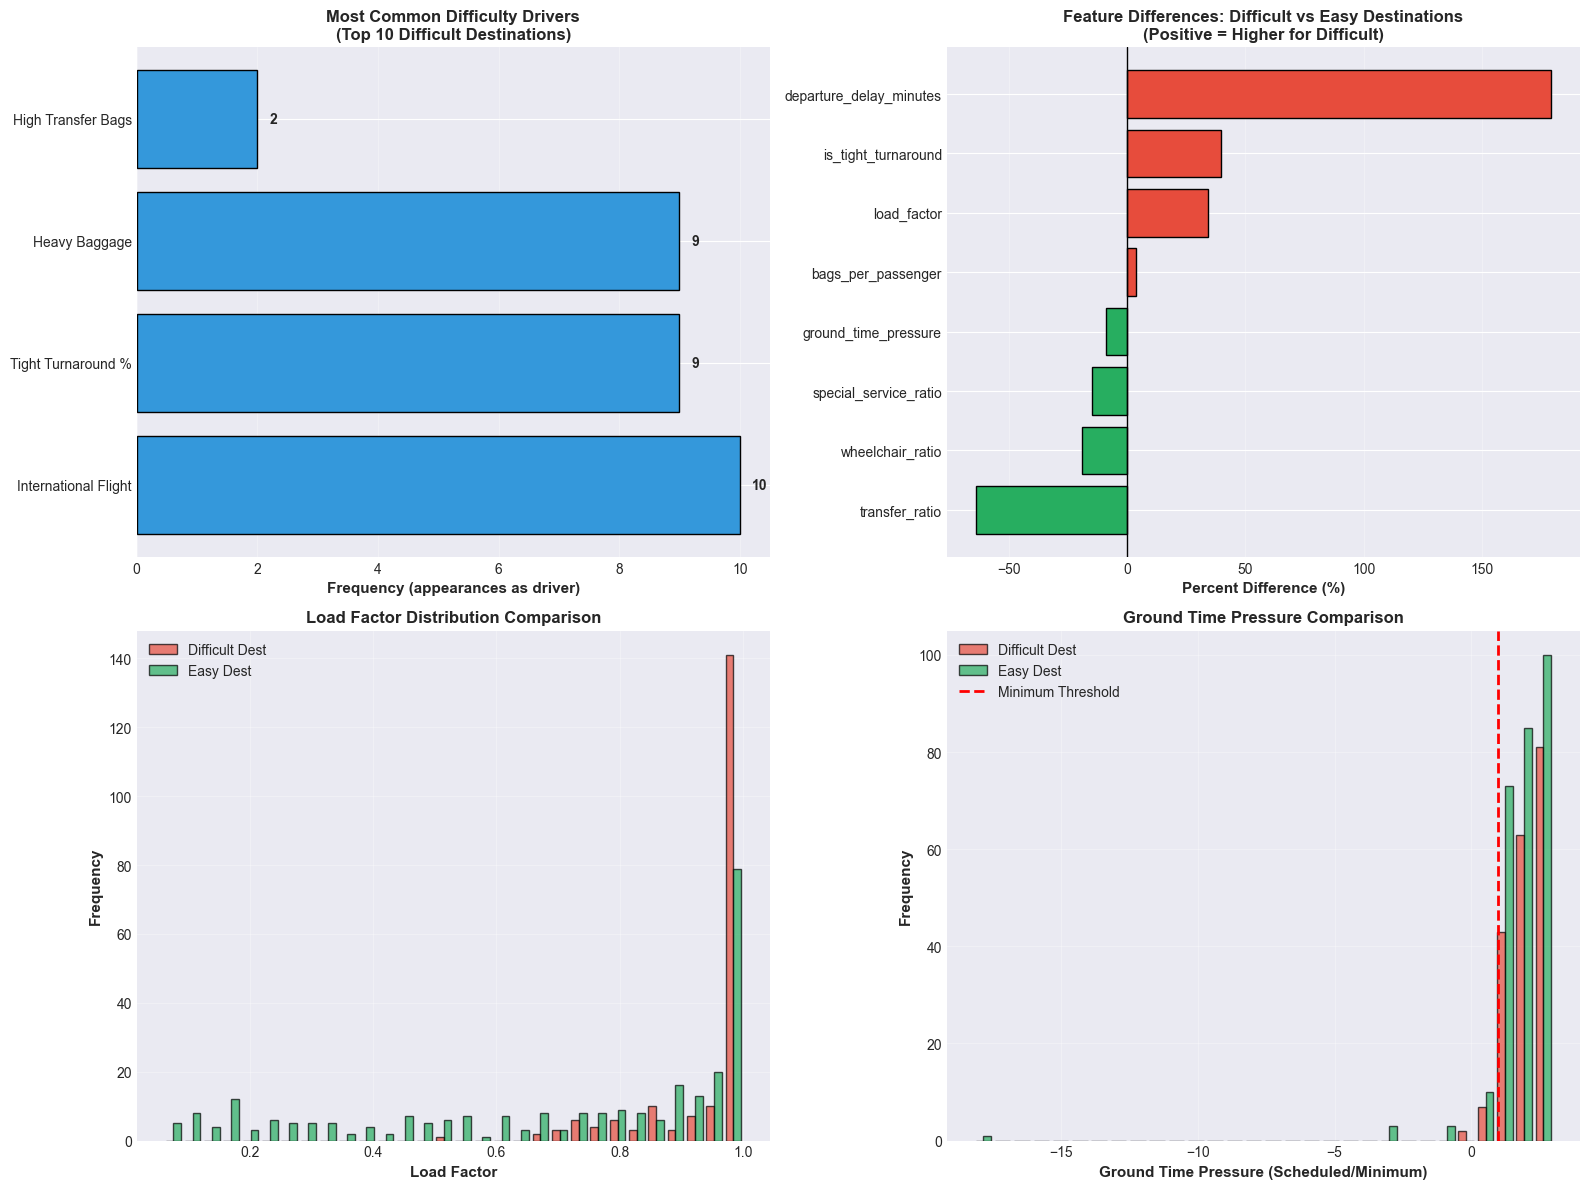


✓ Visualization saved as 'driver_patterns_analysis.png'


In [35]:
# Visualize Driver Patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Driver frequency bar chart
drivers_sorted = sorted(driver_frequency.items(), key=lambda x: x[1], reverse=True)
driver_names = [d[0] for d in drivers_sorted]
driver_counts = [d[1] for d in drivers_sorted]

axes[0, 0].barh(range(len(driver_names)), driver_counts, color='#3498db', edgecolor='black')
axes[0, 0].set_yticks(range(len(driver_names)))
axes[0, 0].set_yticklabels(driver_names)
axes[0, 0].set_xlabel('Frequency (appearances as driver)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Most Common Difficulty Drivers\n(Top 10 Difficult Destinations)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Add count labels
for i, v in enumerate(driver_counts):
    axes[0, 0].text(v + 0.2, i, str(v), va='center', fontweight='bold')

# 2. Feature comparison - difficult vs easy
comparison_sorted = comparison_df.sort_values('Percent_Diff', ascending=True)
colors = ['#27ae60' if x < 0 else '#e74c3c' for x in comparison_sorted['Percent_Diff']]

axes[0, 1].barh(range(len(comparison_sorted)), comparison_sorted['Percent_Diff'],
                color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(len(comparison_sorted)))
axes[0, 1].set_yticklabels(comparison_sorted['Feature'])
axes[0, 1].set_xlabel('Percent Difference (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Feature Differences: Difficult vs Easy Destinations\n(Positive = Higher for Difficult)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axvline(0, color='black', linewidth=1)
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Distribution comparison - load factor
axes[1, 0].hist([difficult_flights['load_factor'], easy_flights['load_factor']],
                bins=30, label=['Difficult Dest', 'Easy Dest'],
                color=['#e74c3c', '#27ae60'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Load Factor', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Load Factor Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Distribution comparison - ground time pressure
axes[1, 1].hist([difficult_flights['ground_time_pressure'].clip(upper=3), 
                 easy_flights['ground_time_pressure'].clip(upper=3)],
                bins=30, label=['Difficult Dest', 'Easy Dest'],
                color=['#e74c3c', '#27ae60'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Ground Time Pressure (Scheduled/Minimum)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Ground Time Pressure Comparison', fontsize=12, fontweight='bold')
axes[1, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Minimum Threshold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('driver_patterns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'driver_patterns_analysis.png'")

In [36]:
# Cluster Destinations by Difficulty Profile
print("\n" + "="*80)
print("ANALYSIS 3: DESTINATION CLUSTERING BY DIFFICULTY PROFILE")
print("="*80)


# Prepare features for clustering
clustering_features = [
    'avg_difficulty', 'pct_difficult', 'avg_delay',
    'avg_load_factor', 'avg_ground_pressure', 'avg_bags_per_pax',
    'avg_transfer_ratio', 'avg_ssr_ratio', 'avg_wheelchair_ratio'
]

# Filter for destinations with enough data
cluster_data = significant_destinations[significant_destinations['total_flights'] >= 10].copy()
print(f"\nClustering {len(cluster_data)} destinations with ≥10 flights")

# Prepare feature matrix
X = cluster_data[clustering_features].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Use 4 clusters (typical operational categories)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_data['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
print(f"\nCreated {optimal_k} destination clusters")
print("\nCluster Characteristics:")
print("-"*80)

cluster_profiles = cluster_data.groupby('cluster')[clustering_features + ['total_flights']].mean()

for cluster_id in range(optimal_k):
    cluster_dests = cluster_data[cluster_data['cluster'] == cluster_id]
    print(f"\nCLUSTER {cluster_id} ({len(cluster_dests)} destinations):")
    print(f"  Avg Difficulty: {cluster_profiles.loc[cluster_id, 'avg_difficulty']:.1f}")
    print(f"  Avg % Difficult: {cluster_profiles.loc[cluster_id, 'pct_difficult']:.1f}%")
    print(f"  Avg Delay: {cluster_profiles.loc[cluster_id, 'avg_delay']:.1f} min")
    print(f"  Avg Load Factor: {cluster_profiles.loc[cluster_id, 'avg_load_factor']:.2f}")
    print(f"  Sample Destinations: {', '.join(cluster_dests.head(5).index.tolist())}")

# Assign descriptive names to clusters based on characteristics
cluster_names = {}
for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    
    if profile['avg_difficulty'] >= 65 and profile['pct_difficult'] >= 35:
        cluster_names[cluster_id] = 'High Risk Operations'
    elif profile['avg_difficulty'] >= 55 and profile['avg_delay'] >= 10:
        cluster_names[cluster_id] = 'Delay-Prone Routes'
    elif profile['avg_load_factor'] >= 0.8 and profile['avg_ssr_ratio'] >= 0.05:
        cluster_names[cluster_id] = 'High Service Demand'
    elif profile['avg_difficulty'] <= 45:
        cluster_names[cluster_id] = 'Standard Operations'
    else:
        cluster_names[cluster_id] = 'Mixed Complexity'

cluster_data['cluster_name'] = cluster_data['cluster'].map(cluster_names)

print("\nCluster Names Assigned:")
for cluster_id, name in cluster_names.items():
    count = (cluster_data['cluster'] == cluster_id).sum()
    print(f"  Cluster {cluster_id}: {name} ({count} destinations)")

# Export cluster assignments
cluster_data[['total_flights', 'avg_difficulty', 'pct_difficult', 
              'cluster', 'cluster_name']].to_csv('destination_clusters.csv')
print("\n✓ Exported to 'destination_clusters.csv'")


ANALYSIS 3: DESTINATION CLUSTERING BY DIFFICULTY PROFILE

Clustering 168 destinations with ≥10 flights

Created 4 destination clusters

Cluster Characteristics:
--------------------------------------------------------------------------------

CLUSTER 0 (72 destinations):
  Avg Difficulty: 43.7
  Avg % Difficult: 27.7%
  Avg Delay: 16.2 min
  Avg Load Factor: 0.96
  Sample Destinations: CUN, PUJ, MCO, SFO, ORF

CLUSTER 1 (25 destinations):
  Avg Difficulty: 61.8
  Avg % Difficult: 92.3%
  Avg Delay: 41.5 min
  Avg Load Factor: 0.94
  Sample Destinations: BRU, GRU, CDG, FRA, EDI

CLUSTER 2 (67 destinations):
  Avg Difficulty: 34.6
  Avg % Difficult: 9.7%
  Avg Delay: 22.7 min
  Avg Load Factor: 0.90
  Sample Destinations: FAI, ANC, YWG, OMA, SYR

CLUSTER 3 (4 destinations):
  Avg Difficulty: 44.5
  Avg % Difficult: 42.4%
  Avg Delay: 10.0 min
  Avg Load Factor: 0.82
  Sample Destinations: MEX, MTY, FNT, DEC

Cluster Names Assigned:
  Cluster 0: Standard Operations (72 destinations)
  Cl

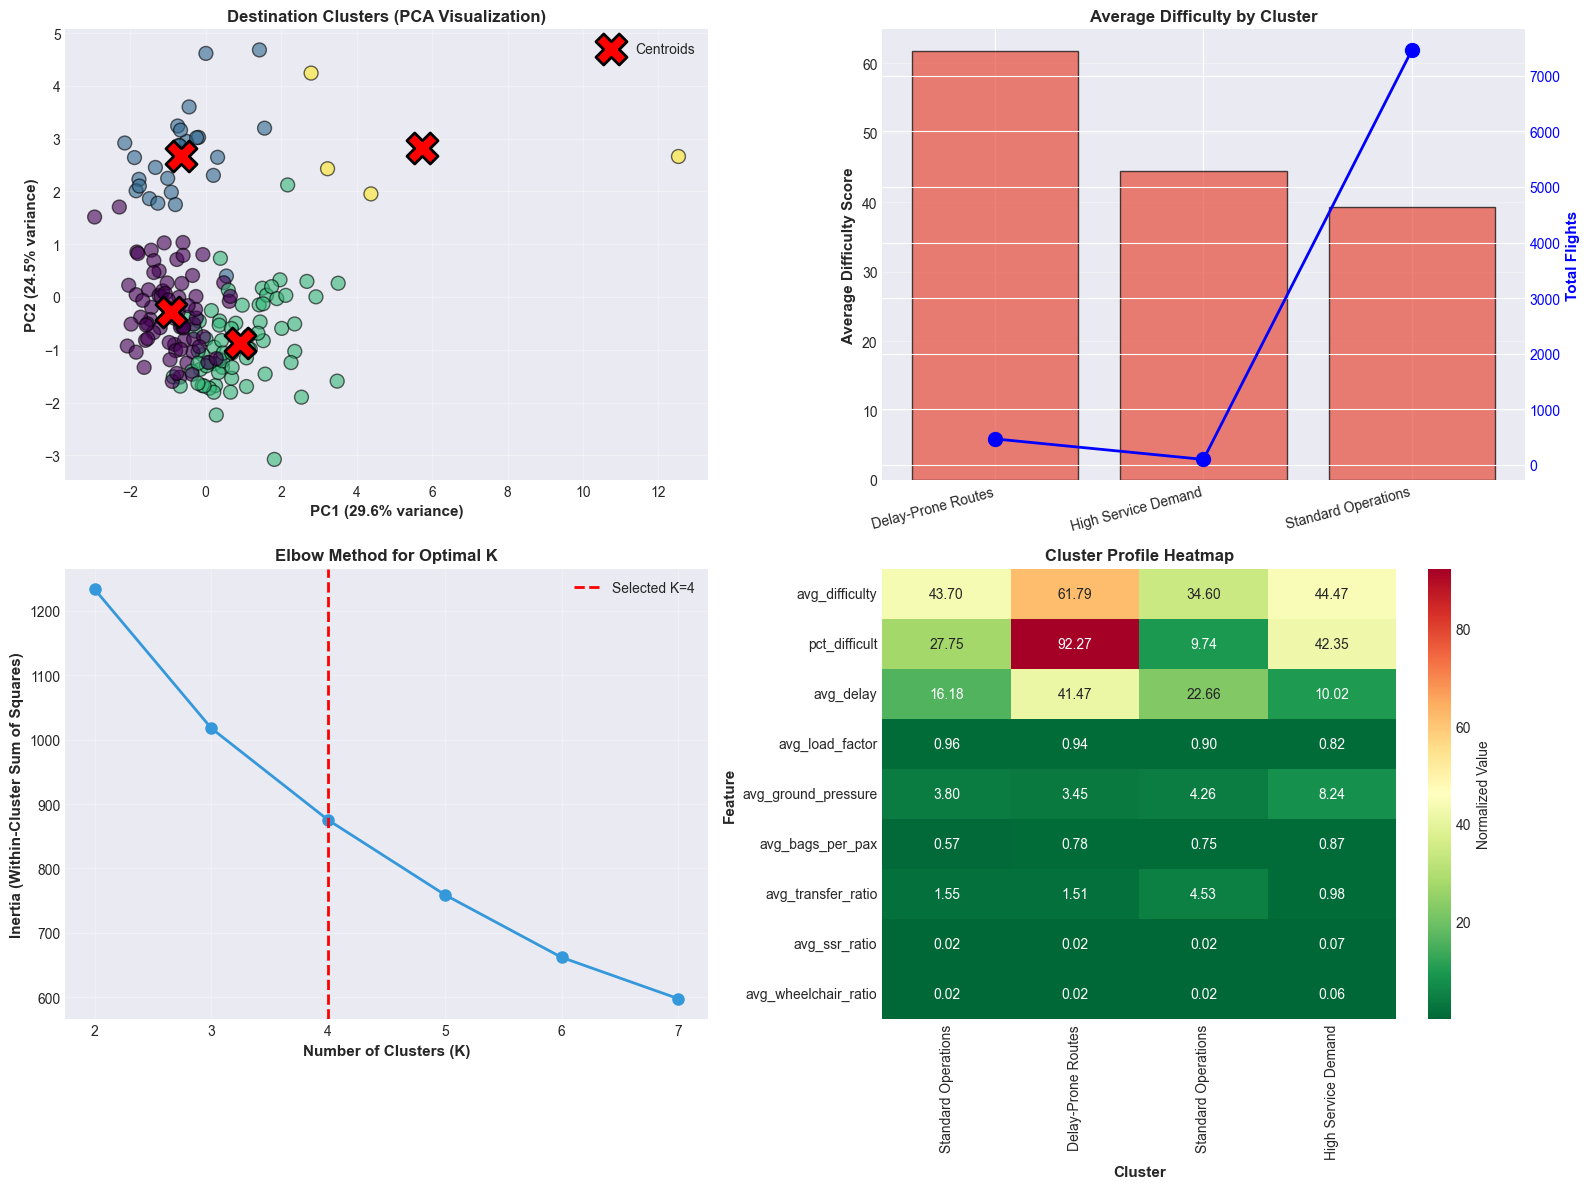


✓ Visualization saved as 'cluster_analysis.png'


In [38]:
# Visualize Clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA visualization of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=cluster_data['cluster'], 
                             cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
                      fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
                      fontsize=11, fontweight='bold')
axes[0, 0].set_title('Destination Clusters (PCA Visualization)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Add cluster centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
axes[0, 0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                   marker='X', s=500, c='red', edgecolors='black', linewidth=2,
                   label='Centroids')
axes[0, 0].legend()

# 2. Cluster size and average difficulty
cluster_summary = cluster_data.groupby('cluster_name').agg({
    'total_flights': 'sum',
    'avg_difficulty': 'mean'
}).sort_values('avg_difficulty', ascending=False)

x_pos = np.arange(len(cluster_summary))
axes[0, 1].bar(x_pos, cluster_summary['avg_difficulty'], 
               color='#e74c3c', alpha=0.7, edgecolor='black', label='Avg Difficulty')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(cluster_summary.index, rotation=15, ha='right')
axes[0, 1].set_ylabel('Average Difficulty Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Average Difficulty by Cluster', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add flight count on secondary axis
ax2 = axes[0, 1].twinx()
ax2.plot(x_pos, cluster_summary['total_flights'], 
         color='blue', marker='o', linewidth=2, markersize=10, label='Total Flights')
ax2.set_ylabel('Total Flights', fontsize=11, fontweight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 3. Elbow curve for cluster selection
axes[1, 0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='#3498db')
axes[1, 0].axvline(optimal_k, color='red', linestyle='--', linewidth=2, 
                   label=f'Selected K={optimal_k}')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Elbow Method for Optimal K', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Heatmap of cluster profiles
profile_for_heatmap = cluster_profiles[clustering_features].T
sns.heatmap(profile_for_heatmap, annot=True, fmt='.2f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Normalized Value'}, ax=axes[1, 1],
            xticklabels=[cluster_names[i] for i in range(optimal_k)])
axes[1, 1].set_xlabel('Cluster', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Feature', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Cluster Profile Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'cluster_analysis.png'")


In [39]:
# Identify High-Risk Flight Patterns
print("\n" + "="*80)
print("ANALYSIS 4: HIGH-RISK FLIGHT PATTERN IDENTIFICATION")
print("="*80)

# Define high-risk criteria (multiple factors present)
master_data['risk_score'] = 0

# Add risk points for each factor
if 'is_tight_turnaround' in master_data.columns:
    master_data['risk_score'] += master_data['is_tight_turnaround'] * 2  # 2 points

if 'load_factor' in master_data.columns:
    master_data['risk_score'] += (master_data['load_factor'] >= 0.85).astype(int) * 2  # 2 points

if 'special_service_ratio' in master_data.columns:
    high_ssr_threshold = master_data['special_service_ratio'].quantile(0.75)
    master_data['risk_score'] += (master_data['special_service_ratio'] > high_ssr_threshold).astype(int)  # 1 point

if 'transfer_ratio' in master_data.columns:
    high_transfer_threshold = master_data['transfer_ratio'].quantile(0.75)
    master_data['risk_score'] += (master_data['transfer_ratio'] > high_transfer_threshold).astype(int)  # 1 point

if 'bags_per_passenger' in master_data.columns:
    high_bags_threshold = master_data['bags_per_passenger'].quantile(0.75)
    master_data['risk_score'] += (master_data['bags_per_passenger'] > high_bags_threshold).astype(int)  # 1 point

# Categorize risk levels
def categorize_risk(score):
    if score >= 5:
        return 'Critical Risk'
    elif score >= 3:
        return 'High Risk'
    elif score >= 2:
        return 'Moderate Risk'
    else:
        return 'Low Risk'

master_data['risk_category'] = master_data['risk_score'].apply(categorize_risk)

# Risk distribution
print("\nRisk Category Distribution:")
risk_dist = master_data['risk_category'].value_counts()
for category in ['Critical Risk', 'High Risk', 'Moderate Risk', 'Low Risk']:
    if category in risk_dist:
        count = risk_dist[category]
        pct = (count / len(master_data)) * 100
        print(f"  {category}: {count:,} flights ({pct:.1f}%)")

# High-risk flights by destination
high_risk_by_dest = master_data[master_data['risk_category'].isin(['Critical Risk', 'High Risk'])].groupby(
    'scheduled_arrival_station_code'
).agg({
    'flight_id': 'count',
    'risk_score': 'mean',
    'departure_delay_minutes': 'mean',
    'difficulty_score_scaled': 'mean'
}).round(2)

high_risk_by_dest.columns = ['high_risk_flight_count', 'avg_risk_score', 
                              'avg_delay', 'avg_difficulty']
high_risk_by_dest = high_risk_by_dest.sort_values('high_risk_flight_count', ascending=False)

print("\nTop 15 Destinations by High-Risk Flight Count:")
print(high_risk_by_dest.head(15).to_string())


ANALYSIS 4: HIGH-RISK FLIGHT PATTERN IDENTIFICATION

Risk Category Distribution:
  Critical Risk: 446 flights (5.5%)
  High Risk: 3,570 flights (44.1%)
  Moderate Risk: 3,316 flights (40.9%)
  Low Risk: 767 flights (9.5%)

Top 15 Destinations by High-Risk Flight Count:
                                high_risk_flight_count  avg_risk_score  avg_delay  avg_difficulty
scheduled_arrival_station_code                                                                   
STL                                                 96            3.80      25.75           36.07
MKE                                                 82            3.45      22.56           32.15
IAH                                                 75            3.47      26.31           51.92
GRR                                                 70            3.61      18.93           40.99
ATW                                                 70            3.54      18.66           33.71
GRB                                        

In [40]:
# Time-Based Risk Patterns
print("\n" + "="*80)
print("ANALYSIS 5: TEMPORAL RISK PATTERNS")
print("="*80)

# Add hour and day of week
master_data['day_of_week'] = pd.to_datetime(master_data['scheduled_departure_date_local']).dt.day_name()
master_data['hour'] = pd.to_datetime(master_data['scheduled_departure_date_local']).dt.hour

# Risk by time of day
if 'time_of_day' in master_data.columns:
    risk_by_time = master_data.groupby('time_of_day').agg({
        'risk_score': 'mean',
        'difficulty_score_scaled': 'mean',
        'flight_id': 'count'
    }).round(2)
    risk_by_time.columns = ['avg_risk_score', 'avg_difficulty', 'flight_count']
    
    print("\nRisk Patterns by Time of Day:")
    print(risk_by_time.to_string())

# Risk by day of week
risk_by_day = master_data.groupby('day_of_week').agg({
    'risk_score': 'mean',
    'difficulty_score_scaled': 'mean',
    'flight_id': 'count'
}).round(2)
risk_by_day.columns = ['avg_risk_score', 'avg_difficulty', 'flight_count']

# Reorder by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
risk_by_day = risk_by_day.reindex([d for d in day_order if d in risk_by_day.index])

print("\nRisk Patterns by Day of Week:")
print(risk_by_day.to_string())


ANALYSIS 5: TEMPORAL RISK PATTERNS

Risk Patterns by Time of Day:
              avg_risk_score  avg_difficulty  flight_count
time_of_day                                               
Evening_Peak            2.71           44.71          2116
Midday                  2.76           40.40          4059
Morning_Peak            2.26           42.50          1356
Off_Peak                2.41           35.66           568

Risk Patterns by Day of Week:
             avg_risk_score  avg_difficulty  flight_count
day_of_week                                              
Monday                 2.57           39.11          1135
Tuesday                2.43           42.45          1000
Wednesday              2.60           41.60          1031
Thursday               2.68           41.84          1114
Friday                 2.62           39.85          1673
Saturday               2.91           44.35          1041
Sunday                 2.66           42.83          1105


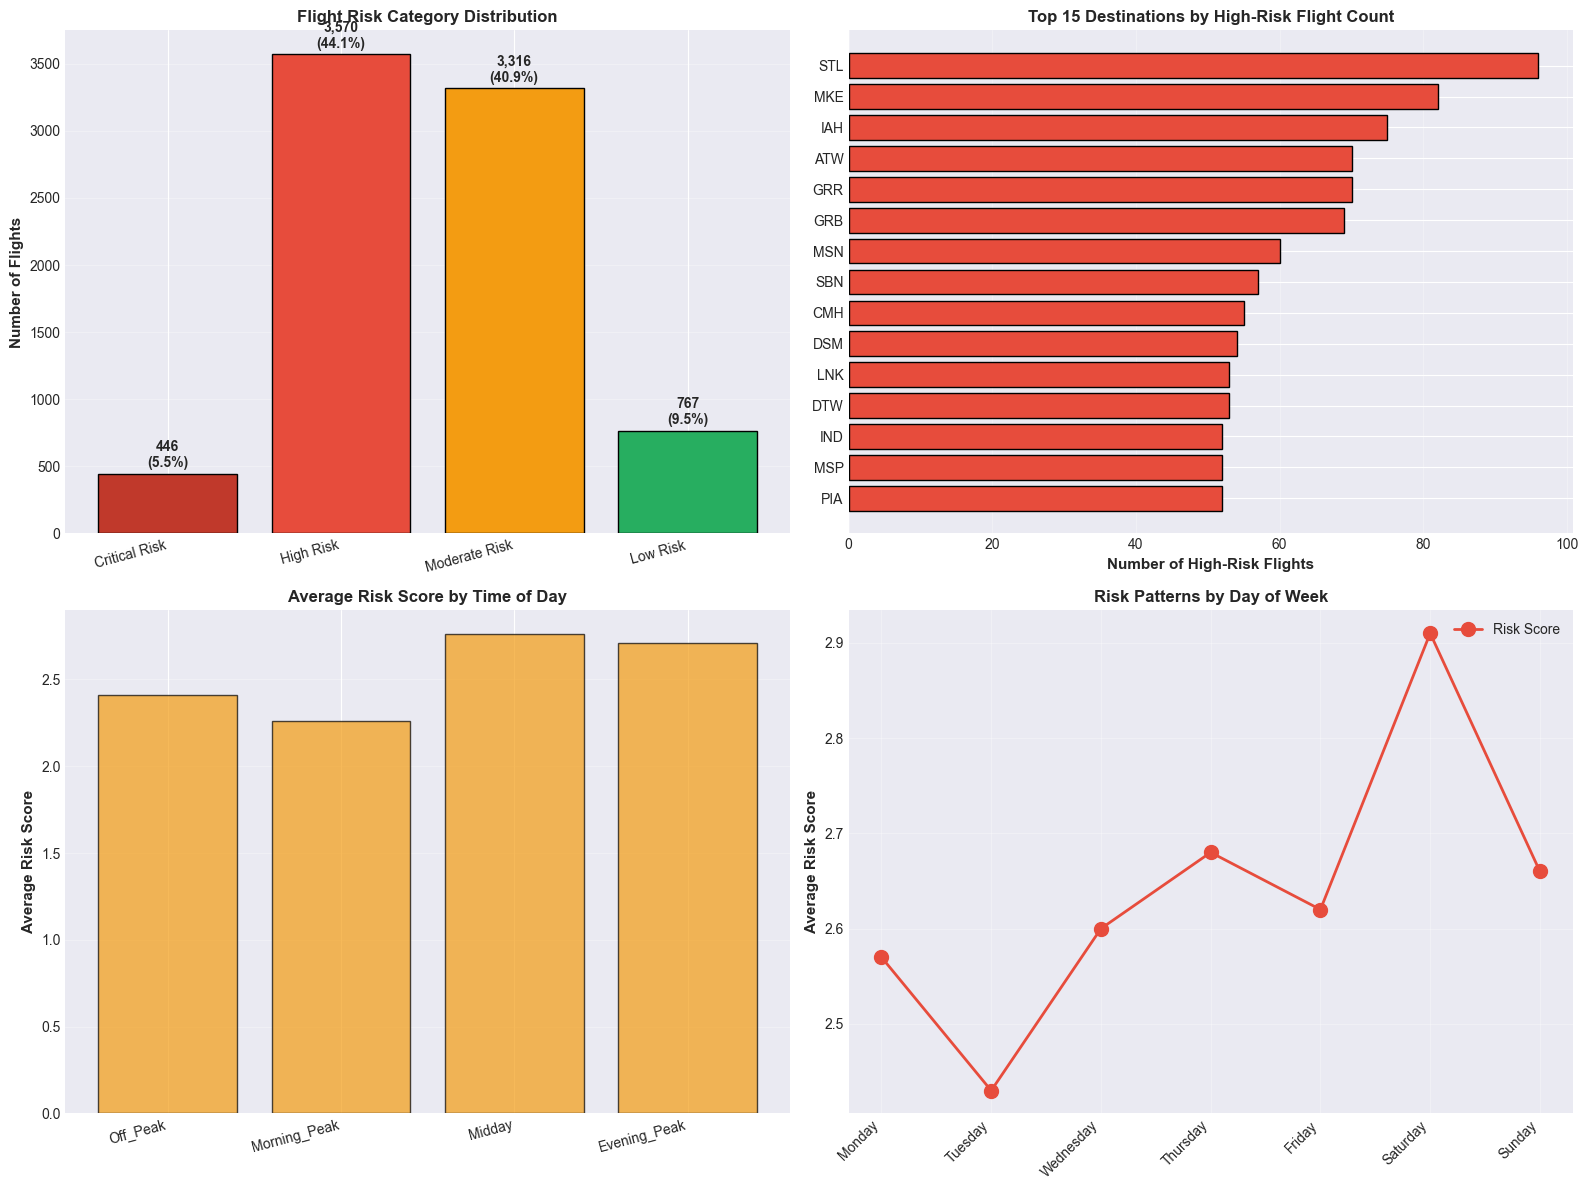


✓ Visualization saved as 'risk_patterns_analysis.png'


In [41]:
# Visualize Risk Patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk category distribution
risk_counts = master_data['risk_category'].value_counts()
risk_order = ['Critical Risk', 'High Risk', 'Moderate Risk', 'Low Risk']
risk_counts = risk_counts.reindex([r for r in risk_order if r in risk_counts.index])
colors_risk = {'Critical Risk': '#c0392b', 'High Risk': '#e74c3c', 
               'Moderate Risk': '#f39c12', 'Low Risk': '#27ae60'}

axes[0, 0].bar(range(len(risk_counts)), risk_counts.values,
               color=[colors_risk[cat] for cat in risk_counts.index], edgecolor='black')
axes[0, 0].set_xticks(range(len(risk_counts)))
axes[0, 0].set_xticklabels(risk_counts.index, rotation=15, ha='right')
axes[0, 0].set_ylabel('Number of Flights', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Flight Risk Category Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for i, v in enumerate(risk_counts.values):
    pct = (v / len(master_data)) * 100
    axes[0, 0].text(i, v + 50, f'{v:,}\n({pct:.1f}%)', 
                    ha='center', fontweight='bold')

# 2. Top destinations by high-risk flights
top_risk_dest = high_risk_by_dest.head(15).sort_values('high_risk_flight_count')
axes[0, 1].barh(range(len(top_risk_dest)), top_risk_dest['high_risk_flight_count'],
                color='#e74c3c', edgecolor='black')
axes[0, 1].set_yticks(range(len(top_risk_dest)))
axes[0, 1].set_yticklabels(top_risk_dest.index)
axes[0, 1].set_xlabel('Number of High-Risk Flights', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 15 Destinations by High-Risk Flight Count', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Risk by time of day
if 'time_of_day' in master_data.columns:
    time_order = ['Off_Peak', 'Morning_Peak', 'Midday', 'Evening_Peak']
    risk_by_time_ordered = risk_by_time.reindex([t for t in time_order if t in risk_by_time.index])
    
    x_pos = np.arange(len(risk_by_time_ordered))
    axes[1, 0].bar(x_pos, risk_by_time_ordered['avg_risk_score'],
                   color='#f39c12', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(risk_by_time_ordered.index, rotation=15, ha='right')
    axes[1, 0].set_ylabel('Average Risk Score', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Average Risk Score by Time of Day', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Risk by day of week
axes[1, 1].plot(range(len(risk_by_day)), risk_by_day['avg_risk_score'],
                marker='o', linewidth=2, markersize=10, color='#e74c3c', label='Risk Score')
axes[1, 1].set_xticks(range(len(risk_by_day)))
axes[1, 1].set_xticklabels(risk_by_day.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Average Risk Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Risk Patterns by Day of Week', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('risk_patterns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'risk_patterns_analysis.png'")

In [42]:
# Generate Destination-Specific Recommendations
print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS: DESTINATION-SPECIFIC STRATEGIES")
print("="*80)

def generate_destination_recommendations(dest_code, dest_data, flight_data):
    """Generate specific recommendations for a destination based on its patterns"""
    
    recommendations = []
    dest_flights = flight_data[flight_data['scheduled_arrival_station_code'] == dest_code]
    
    # Check ground time issues
    tight_turnaround_pct = (dest_flights['is_tight_turnaround'].sum() / len(dest_flights)) * 100
    if tight_turnaround_pct > 30:
        recommendations.append({
            'Issue': 'Tight Turnaround Times',
            'Severity': 'High' if tight_turnaround_pct > 50 else 'Medium',
            'Action': f'Pre-position ground crew; {tight_turnaround_pct:.0f}% of flights have tight turnarounds',
            'Resources': 'Additional ramp agents, expedited boarding procedures'
        })
    
    # Check load factor
    avg_load = dest_flights['load_factor'].mean()
    if avg_load > 0.85:
        recommendations.append({
            'Issue': 'High Passenger Load',
            'Severity': 'High' if avg_load > 0.90 else 'Medium',
            'Action': f'Allocate extra gate agents for boarding; avg load factor {avg_load:.1%}',
            'Resources': 'Additional gate agents, priority boarding management'
        })
    
    # Check baggage volume
    avg_bags_per_pax = dest_flights['bags_per_passenger'].mean()
    if avg_bags_per_pax > 1.2:
        recommendations.append({
            'Issue': 'Heavy Baggage Volume',
            'Severity': 'High' if avg_bags_per_pax > 1.5 else 'Medium',
            'Action': f'Increase baggage handling capacity; avg {avg_bags_per_pax:.2f} bags/passenger',
            'Resources': 'Additional baggage handlers, equipment pre-staging'
        })
    
    # Check transfer bags
    avg_transfer_ratio = dest_flights['transfer_ratio'].mean()
    if avg_transfer_ratio > 0.30:
        recommendations.append({
            'Issue': 'High Transfer Bag Ratio',
            'Severity': 'High' if avg_transfer_ratio > 0.50 else 'Medium',
            'Action': f'Expedite transfer bag processing; {avg_transfer_ratio:.1%} are transfers',
            'Resources': 'Dedicated transfer bag team, expedited routing'
        })
    
    # Check special services
    avg_ssr = dest_flights['special_service_ratio'].mean()
    if avg_ssr > 0.05:
        recommendations.append({
            'Issue': 'High Special Service Requests',
            'Severity': 'High' if avg_ssr > 0.10 else 'Medium',
            'Action': f'Pre-position assistance teams; {avg_ssr:.1%} passengers need special services',
            'Resources': 'Wheelchair assistance, customer service specialists'
        })
    
    # Check delays
    avg_delay = dest_flights['departure_delay_minutes'].mean()
    if avg_delay > 15:
        recommendations.append({
            'Issue': 'Chronic Delays',
            'Severity': 'High' if avg_delay > 30 else 'Medium',
            'Action': f'Review scheduling and ops procedures; avg delay {avg_delay:.1f} minutes',
            'Resources': 'Ops review team, schedule buffer analysis'
        })
    
    return recommendations

# Generate recommendations for top 10 difficult destinations
print("\nDETAILED RECOMMENDATIONS FOR TOP 10 DIFFICULT DESTINATIONS:")
print("="*80)

all_recommendations = []

for i, dest in enumerate(top_difficult_destinations.head(10).index, 1):
    dest_info = top_difficult_destinations.loc[dest]
    recommendations = generate_destination_recommendations(dest, dest_info, master_data)
    
    print(f"\n{i}. {dest}")
    print(f"   Difficulty Score: {dest_info['avg_difficulty']:.1f} | Flights: {int(dest_info['total_flights'])}")
    print(f"   {'-'*70}")
    
    if recommendations:
        for rec in recommendations:
            print(f"   ⚠ {rec['Issue']} [{rec['Severity']} Priority]")
            print(f"      → {rec['Action']}")
            print(f"      Resources: {rec['Resources']}")
            print()
            
            all_recommendations.append({
                'Destination': dest,
                'Issue': rec['Issue'],
                'Severity': rec['Severity'],
                'Action': rec['Action'],
                'Resources': rec['Resources']
            })
    else:
        print(f"   ✓ No critical issues identified")

# Export recommendations
recommendations_df = pd.DataFrame(all_recommendations)
recommendations_df.to_csv('destination_recommendations.csv', index=False)
print("\n✓ Exported to 'destination_recommendations.csv'")


ACTIONABLE RECOMMENDATIONS: DESTINATION-SPECIFIC STRATEGIES

DETAILED RECOMMENDATIONS FOR TOP 10 DIFFICULT DESTINATIONS:

1. BRU
   Difficulty Score: 83.6 | Flights: 15
   ----------------------------------------------------------------------
   ⚠ Tight Turnaround Times [Medium Priority]
      → Pre-position ground crew; 33% of flights have tight turnarounds
      Resources: Additional ramp agents, expedited boarding procedures

   ⚠ High Passenger Load [High Priority]
      → Allocate extra gate agents for boarding; avg load factor 99.3%
      Resources: Additional gate agents, priority boarding management

   ⚠ High Transfer Bag Ratio [High Priority]
      → Expedite transfer bag processing; 242.9% are transfers
      Resources: Dedicated transfer bag team, expedited routing

   ⚠ Chronic Delays [High Priority]
      → Review scheduling and ops procedures; avg delay 42.7 minutes
      Resources: Ops review team, schedule buffer analysis


2. GRU
   Difficulty Score: 68.8 | Flights: 

In [43]:
# Strategic Resource Allocation Recommendations
print("\n" + "="*80)
print("STRATEGIC RESOURCE ALLOCATION RECOMMENDATIONS")
print("="*80)

# Aggregate resource needs across all difficult destinations
resource_needs = Counter()
severity_counts = Counter()

for rec in all_recommendations:
    resource_needs[rec['Issue']] += 1
    severity_counts[rec['Severity']] += 1

print("\nMost Common Issues Across Difficult Destinations:")
for issue, count in resource_needs.most_common():
    pct = (count / len(top_difficult_destinations.head(10))) * 100
    print(f"  • {issue}: {count} destinations ({pct:.0f}%)")

print("\nSeverity Distribution:")
for severity in ['High', 'Medium', 'Low']:
    if severity in severity_counts:
        count = severity_counts[severity]
        print(f"  • {severity} Priority: {count} issues")


STRATEGIC RESOURCE ALLOCATION RECOMMENDATIONS

Most Common Issues Across Difficult Destinations:
  • High Passenger Load: 10 destinations (100%)
  • High Transfer Bag Ratio: 10 destinations (100%)
  • Chronic Delays: 10 destinations (100%)
  • Tight Turnaround Times: 1 destinations (10%)

Severity Distribution:
  • High Priority: 28 issues
  • Medium Priority: 3 issues


In [44]:
# Time-Based Staffing Recommendations
print("\n" + "="*80)
print("TIME-BASED STAFFING RECOMMENDATIONS")
print("="*80)

# Calculate average difficulty and risk by hour of day
if 'time_of_day' in master_data.columns:
    hourly_metrics = master_data.groupby('time_of_day').agg({
        'difficulty_score_scaled': 'mean',
        'risk_score': 'mean',
        'flight_id': 'count',
        'is_tight_turnaround': 'sum',
        'special_service_ratio': 'mean'
    }).round(2)
    
    hourly_metrics.columns = ['avg_difficulty', 'avg_risk', 'flight_count', 
                               'tight_turnarounds', 'avg_ssr']
    
    print("\nStaffing Recommendations by Time Period:")
    print("-"*80)
    
    for period in hourly_metrics.index:
        metrics = hourly_metrics.loc[period]
        print(f"\n{period.replace('_', ' ').title()}:")
        print(f"  Flights: {int(metrics['flight_count'])}")
        print(f"  Avg Difficulty: {metrics['avg_difficulty']:.1f}")
        print(f"  Avg Risk Score: {metrics['avg_risk']:.2f}")
        
        # Staffing level recommendation
        if metrics['avg_difficulty'] >= 55 or metrics['avg_risk'] >= 2.5:
            staffing = "HIGH"
            print(f"  ⚠ RECOMMENDED STAFFING: {staffing}")
            print(f"     → Full crew complement + surge capacity")
        elif metrics['avg_difficulty'] >= 45 or metrics['avg_risk'] >= 1.5:
            staffing = "MEDIUM"
            print(f"  → RECOMMENDED STAFFING: {staffing}")
            print(f"     → Standard crew with on-call backup")
        else:
            staffing = "STANDARD"
            print(f"  ✓ RECOMMENDED STAFFING: {staffing}")
            print(f"     → Base crew levels sufficient")
        
        # Specific recommendations
        if int(metrics['tight_turnarounds']) > 5:
            print(f"     → Extra ramp agents needed ({int(metrics['tight_turnarounds'])} tight turnarounds)")
        if metrics['avg_ssr'] > 0.05:
            print(f"     → Pre-position wheelchair assistance teams")


TIME-BASED STAFFING RECOMMENDATIONS

Staffing Recommendations by Time Period:
--------------------------------------------------------------------------------

Evening Peak:
  Flights: 2116
  Avg Difficulty: 44.7
  Avg Risk Score: 2.71
  ⚠ RECOMMENDED STAFFING: HIGH
     → Full crew complement + surge capacity
     → Extra ramp agents needed (206 tight turnarounds)

Midday:
  Flights: 4059
  Avg Difficulty: 40.4
  Avg Risk Score: 2.76
  ⚠ RECOMMENDED STAFFING: HIGH
     → Full crew complement + surge capacity
     → Extra ramp agents needed (419 tight turnarounds)

Morning Peak:
  Flights: 1356
  Avg Difficulty: 42.5
  Avg Risk Score: 2.26
  → RECOMMENDED STAFFING: MEDIUM
     → Standard crew with on-call backup
     → Extra ramp agents needed (108 tight turnarounds)

Off Peak:
  Flights: 568
  Avg Difficulty: 35.7
  Avg Risk Score: 2.41
  → RECOMMENDED STAFFING: MEDIUM
     → Standard crew with on-call backup
     → Extra ramp agents needed (47 tight turnarounds)


In [45]:
# Schedule Optimization Recommendations
print("\n" + "="*80)
print("SCHEDULE OPTIMIZATION RECOMMENDATIONS")
print("="*80)

# Identify flights that consistently underperform
chronic_delay_flights = master_data.groupby(['scheduled_arrival_station_code', 
                                              'flight_number']).agg({
    'departure_delay_minutes': 'mean',
    'difficulty_score_scaled': 'mean',
    'ground_time_pressure': 'mean',
    'flight_id': 'count'
}).reset_index()

chronic_delay_flights.columns = ['destination', 'flight_number', 'avg_delay', 
                                  'avg_difficulty', 'avg_ground_pressure', 'occurrences']

# Filter for flights with consistent issues
problem_flights = chronic_delay_flights[
    (chronic_delay_flights['avg_delay'] > 20) & 
    (chronic_delay_flights['occurrences'] >= 3)
].sort_values('avg_delay', ascending=False)

print(f"\nIdentified {len(problem_flights)} flight numbers with chronic delays (≥3 occurrences, >20 min avg delay)")
print("\nTop 15 Flights Needing Schedule Review:")
print(problem_flights.head(15).to_string(index=False))

# Schedule recommendations
print("\nSchedule Optimization Actions:")
print("-"*80)

schedule_recommendations = []

for idx, flight in problem_flights.head(15).iterrows():
    rec_list = []
    
    if flight['avg_ground_pressure'] < 1.1:
        rec_list.append(f"Increase scheduled ground time (current: {flight['avg_ground_pressure']:.2f}x minimum)")
    
    if flight['avg_delay'] > 30:
        rec_list.append(f"Consider schedule shift to off-peak hours")
    
    if flight['avg_difficulty'] > 65:
        rec_list.append(f"Flag for pre-flight ops briefing")
    
    schedule_recommendations.append({
        'Destination': flight['destination'],
        'Flight_Number': flight['flight_number'],
        'Avg_Delay': round(flight['avg_delay'], 1),
        'Occurrences': int(flight['occurrences']),
        'Recommendations': '; '.join(rec_list) if rec_list else 'Monitor closely'
    })

schedule_df = pd.DataFrame(schedule_recommendations)
schedule_df.to_csv('schedule_optimization_recommendations.csv', index=False)

for rec in schedule_recommendations[:10]:
    print(f"\n{rec['Destination']} - Flight {rec['Flight_Number']}")
    print(f"  Avg Delay: {rec['Avg_Delay']} min ({rec['Occurrences']} occurrences)")
    print(f"  Actions: {rec['Recommendations']}")

print("\n✓ Exported to 'schedule_optimization_recommendations.csv'")


SCHEDULE OPTIMIZATION RECOMMENDATIONS

Identified 237 flight numbers with chronic delays (≥3 occurrences, >20 min avg delay)

Top 15 Flights Needing Schedule Review:
destination  flight_number  avg_delay  avg_difficulty  avg_ground_pressure  occurrences
        ASE           5251 142.411765       35.263664             3.958478           17
        SBN           5274 123.866667       30.074556             2.744828           15
        STL           4518 103.000000       33.140011             3.265413           15
        FRA            907  95.200000       74.776864             1.946366           15
        LAX           2155  93.600000       49.051306            22.505419           15
        LHR            920  92.600000       62.326819             7.154023           15
        LAF           5051  90.700000       12.076274             2.134483           10
        LNK           5314  87.800000       42.276986            -0.082759           15
        GSO           4188  85.733333    

In [ ]:
# Investment Prioritization Matrix
print("\n" + "="*80)
print("INVESTMENT PRIORITIZATION MATRIX")
print("="*80)

# Calculate impact and frequency for each issue type
investment_priorities = []

for issue, count in resource_needs.most_common():
    # Get avg delay impact for flights with this issue
    issue_keyword_map = {
        'Tight Turnaround Times': 'is_tight_turnaround',
        'High Passenger Load': 'load_factor',
        'Heavy Baggage Volume': 'bags_per_passenger',
        'High Transfer Bag Ratio': 'transfer_ratio',
        'High Special Service Requests': 'special_service_ratio',
        'Chronic Delays': 'departure_delay_minutes'
    }
    
    if issue in issue_keyword_map:
        feature = issue_keyword_map[issue]
        
        if feature in master_data.columns:
            if feature == 'is_tight_turnaround':
                affected_flights = master_data[master_data[feature] == 1]
            elif feature == 'load_factor':
                affected_flights = master_data[master_data[feature] >= 0.85]
            elif feature == 'departure_delay_minutes':
                affected_flights = master_data[master_data[feature] > 15]
            else:
                threshold = master_data[feature].quantile(0.75)
                affected_flights = master_data[master_data[feature] > threshold]
            
            avg_delay_impact = affected_flights['departure_delay_minutes'].mean()
            affected_count = len(affected_flights)
            total_delay_minutes = affected_flights['departure_delay_minutes'].sum()
            
            investment_priorities.append({
                'Issue': issue,
                'Destinations_Affected': count,
                'Flights_Affected': affected_count,
                'Avg_Delay_Impact': round(avg_delay_impact, 1),
                'Total_Delay_Minutes': round(total_delay_minutes, 0),
                'Priority_Score': round(count * affected_count * avg_delay_impact / 1000, 2)
            })

priority_df = pd.DataFrame(investment_priorities).sort_values('Priority_Score', ascending=False)

print("\nInvestment Priorities (Ranked by Impact):")
print("Priority Score = Destinations × Flights × Delay Impact")
print("-"*80)
print(priority_df.to_string(index=False))

priority_df.to_csv('investment_priorities.csv', index=False)
print("\n✓ Exported to 'investment_priorities.csv'")

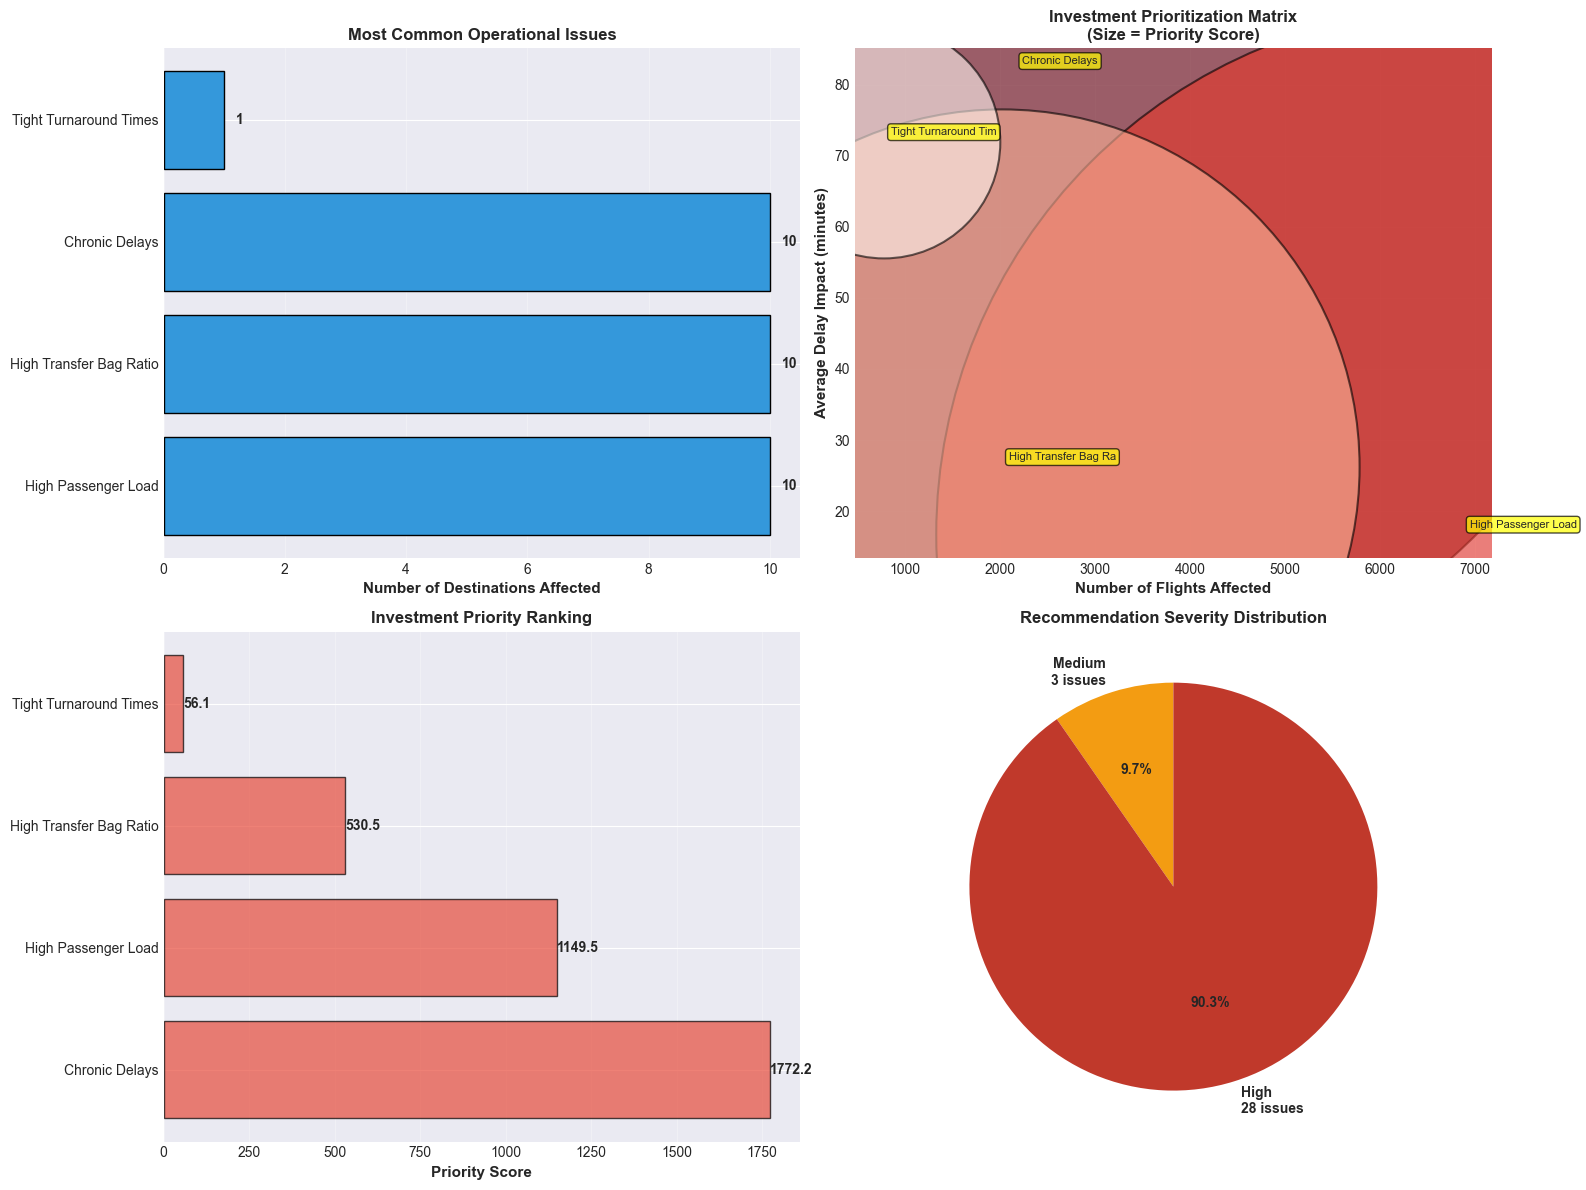


✓ Visualization saved as 'operational_recommendations_summary.png'


In [50]:
# Visualize Recommendations Summary
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Issue frequency
issues_sorted = sorted(resource_needs.items(), key=lambda x: x[1], reverse=True)
issue_names = [i[0] for i in issues_sorted]
issue_counts = [i[1] for i in issues_sorted]

axes[0, 0].barh(range(len(issue_names)), issue_counts, color='#3498db', edgecolor='black')
axes[0, 0].set_yticks(range(len(issue_names)))
axes[0, 0].set_yticklabels(issue_names)
axes[0, 0].set_xlabel('Number of Destinations Affected', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Most Common Operational Issues', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(issue_counts):
    axes[0, 0].text(v + 0.2, i, str(v), va='center', fontweight='bold')

# 2. Investment priority matrix
if len(priority_df) > 0:
    axes[0, 1].scatter(priority_df['Flights_Affected'], 
                       priority_df['Avg_Delay_Impact'],
                       s=priority_df['Priority_Score']*500,
                       alpha=0.6, c=priority_df['Priority_Score'],
                       cmap='Reds', edgecolors='black', linewidth=1.5)
    axes[0, 1].set_xlabel('Number of Flights Affected', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Average Delay Impact (minutes)', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Investment Prioritization Matrix\n(Size = Priority Score)', 
                         fontsize=12, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # Annotate issues
    for idx, row in priority_df.iterrows():
        axes[0, 1].annotate(row['Issue'][:20], 
                            xy=(row['Flights_Affected'], row['Avg_Delay_Impact']),
                            xytext=(5, 5), textcoords='offset points',
                            fontsize=8, bbox=dict(boxstyle='round,pad=0.3', 
                                                 facecolor='yellow', alpha=0.7))

# 3. Priority score ranking
if len(priority_df) > 0:
    axes[1, 0].barh(range(len(priority_df)), priority_df['Priority_Score'],
                    color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[1, 0].set_yticks(range(len(priority_df)))
    axes[1, 0].set_yticklabels(priority_df['Issue'])
    axes[1, 0].set_xlabel('Priority Score', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Investment Priority Ranking', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(priority_df['Priority_Score']):
        axes[1, 0].text(v + 0.5, i, f'{v:.1f}', va='center', fontweight='bold')

# 4. Severity distribution pie chart
severity_data = pd.Series(severity_counts)
colors_sev = {'High': '#c0392b', 'Medium': '#f39c12', 'Low': '#27ae60'}
axes[1, 1].pie(severity_data.values, 
               labels=[f'{idx}\n{severity_data[idx]} issues' for idx in severity_data.index],
               colors=[colors_sev.get(x, 'gray') for x in severity_data.index],
               autopct='%1.1f%%', startangle=90,
               textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1, 1].set_title('Recommendation Severity Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('operational_recommendations_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'operational_recommendations_summary.png'")

In [51]:
# Operational Impact Summary
print("\n" + "="*80)
print("OPERATIONAL IMPACT SUMMARY")
print("="*80)

# Calculate overall impact metrics
total_flights = len(master_data)
difficult_flights = len(master_data[master_data['difficulty_category'] == 'Difficult'])
high_risk_flights = len(master_data[master_data['risk_category'].isin(['Critical Risk', 'High Risk'])])

total_delay_minutes = master_data['departure_delay_minutes'].sum()
difficult_delay_minutes = master_data[master_data['difficulty_category'] == 'Difficult']['departure_delay_minutes'].sum()

avg_delay_all = master_data['departure_delay_minutes'].mean()
avg_delay_difficult = master_data[master_data['difficulty_category'] == 'Difficult']['departure_delay_minutes'].mean()
avg_delay_easy = master_data[master_data['difficulty_category'] == 'Easy']['departure_delay_minutes'].mean()

print("\nFLIGHT DISTRIBUTION:")
print(f"  • Total Flights Analyzed: {total_flights:,}")
print(f"  • Difficult Flights: {difficult_flights:,} ({difficult_flights/total_flights*100:.1f}%)")
print(f"  • High-Risk Flights: {high_risk_flights:,} ({high_risk_flights/total_flights*100:.1f}%)")

print("\nDELAY IMPACT:")
print(f"  • Total Delay Minutes: {total_delay_minutes:,.0f}")
print(f"  • Delay from Difficult Flights: {difficult_delay_minutes:,.0f} ({difficult_delay_minutes/total_delay_minutes*100:.1f}%)")
print(f"  • Average Delay (All Flights): {avg_delay_all:.1f} minutes")
print(f"  • Average Delay (Difficult): {avg_delay_difficult:.1f} minutes")
print(f"  • Average Delay (Easy): {avg_delay_easy:.1f} minutes")
print(f"  • Delay Multiplier: {avg_delay_difficult/avg_delay_easy:.2f}x")

print("\nDESTINATION INSIGHTS:")
print(f"  • Total Destinations: {master_data['scheduled_arrival_station_code'].nunique()}")
print(f"  • Chronically Difficult Destinations: {len(problem_destinations)}")
print(f"  • Destinations Requiring Immediate Attention: {len(top_difficult_destinations.head(10))}")

print("\nRESOURCE ALLOCATION NEEDS:")
print(f"  • Total Recommendations Generated: {len(all_recommendations)}")
print(f"  • High Priority Actions: {severity_counts.get('High', 0)}")
print(f"  • Medium Priority Actions: {severity_counts.get('Medium', 0)}")

# Calculate potential improvement
# Assume reducing difficult flight delays by 30% through targeted interventions
potential_reduction = difficult_delay_minutes * 0.30
print("\nPOTENTIAL IMPROVEMENT (Conservative Estimate):")
print(f"  • If difficult flight delays reduced by 30%:")
print(f"    → Delay minutes saved: {potential_reduction:,.0f} minutes")
print(f"    → Hours saved per day: {potential_reduction/60/15:.1f} hours")  # 15 days of data
print(f"    → Estimated annual savings: {(potential_reduction*365/15)/60:,.0f} hours")

# Create summary dataframe
operational_summary = {
    'Metric': [
        'Total Flights',
        'Difficult Flights',
        'High-Risk Flights',
        'Total Delay Minutes',
        'Avg Delay (All)',
        'Avg Delay (Difficult)',
        'Destinations Analyzed',
        'Chronically Difficult Destinations',
        'Total Recommendations',
        'High Priority Actions',
        'Potential Annual Hours Saved'
    ],
    'Value': [
        f"{total_flights:,}",
        f"{difficult_flights:,} ({difficult_flights/total_flights*100:.1f}%)",
        f"{high_risk_flights:,} ({high_risk_flights/total_flights*100:.1f}%)",
        f"{total_delay_minutes:,.0f}",
        f"{avg_delay_all:.1f} min",
        f"{avg_delay_difficult:.1f} min",
        f"{master_data['scheduled_arrival_station_code'].nunique()}",
        f"{len(problem_destinations)}",
        f"{len(all_recommendations)}",
        f"{severity_counts.get('High', 0)}",
        f"{(potential_reduction*365/15)/60:,.0f}"
    ]
}

summary_df = pd.DataFrame(operational_summary)
summary_df.to_csv('operational_impact_summary.csv', index=False)
print("\n✓ Exported to 'operational_impact_summary.csv'")


OPERATIONAL IMPACT SUMMARY

FLIGHT DISTRIBUTION:
  • Total Flights Analyzed: 8,099
  • Difficult Flights: 2,036 (25.1%)
  • High-Risk Flights: 4,016 (49.6%)

DELAY IMPACT:
  • Total Delay Minutes: 171,577
  • Delay from Difficult Flights: 75,606 (44.1%)
  • Average Delay (All Flights): 21.2 minutes
  • Average Delay (Difficult): 37.1 minutes
  • Average Delay (Easy): 15.1 minutes
  • Delay Multiplier: 2.46x

DESTINATION INSIGHTS:
  • Total Destinations: 188
  • Chronically Difficult Destinations: 65
  • Destinations Requiring Immediate Attention: 10

RESOURCE ALLOCATION NEEDS:
  • Total Recommendations Generated: 31
  • High Priority Actions: 28
  • Medium Priority Actions: 3

POTENTIAL IMPROVEMENT (Conservative Estimate):
  • If difficult flight delays reduced by 30%:
    → Delay minutes saved: 22,682 minutes
    → Hours saved per day: 25.2 hours
    → Estimated annual savings: 9,199 hours

✓ Exported to 'operational_impact_summary.csv'


In [56]:
# COMPREHENSIVE ACTION PLAN
print("\n" + "="*80)
print("COMPREHENSIVE ACTION PLAN: IMMEDIATE & LONG-TERM RECOMMENDATIONS")
print("="*80)

print("\n" + "="*80)
print("PHASE 1: IMMEDIATE ACTIONS (0-30 Days)")
print("="*80)

immediate_actions = [
    {
        'Action': 'Deploy Enhanced Staffing for International Routes',
        'Target': 'BRU, GRU, CDG, FRA, EDI, DUB, SNN, LHR, MUC, FCO',
        'Rationale': '100% of international flights rated as Difficult; avg delay 40+ minutes',
        'Implementation': [
            '→ Pre-position 2-3 additional gate agents for each departure',
            '→ Dedicated wheelchair assistance team on standby',
            '→ Expedited customs/immigration coordination',
            '→ Enhanced baggage handling crew (avg 1.5+ bags/passenger)'
        ]
    },
    {
        'Action': 'Implement Tight Turnaround Protocol',
        'Target': 'All flights with scheduled ground time < 1.2x minimum',
        'Rationale': f'{master_data["is_tight_turnaround"].sum()} flights identified with tight turnarounds',
        'Implementation': [
            '→ Pre-board crew 15 minutes early',
            '→ Priority gate assignment close to arrival gate',
            '→ Ramp crew pre-positioned before arrival',
            '→ Express catering and cleaning protocols'
        ]
    },
    {
        'Action': 'High-Load Flight Support Package',
        'Target': 'All flights with load factor > 85%',
        'Rationale': f'{(master_data["load_factor"] > 0.85).sum()} high-load flights; strong correlation with delays',
        'Implementation': [
            '→ Open boarding 10 minutes earlier',
            '→ Proactive gate bag check for carry-on overflow',
            '→ Additional gate readers for faster scanning',
            '→ Zone-based boarding strictly enforced'
        ]
    }
]

for i, action in enumerate(immediate_actions, 1):
    print(f"\n{i}. {action['Action'].upper()}")
    print(f"   Target: {action['Target']}")
    print(f"   Rationale: {action['Rationale']}")
    print(f"   Implementation Steps:")
    for step in action['Implementation']:
        print(f"      {step}")

print("\n" + "="*80)
print("PHASE 2: SHORT-TERM IMPROVEMENTS (1-3 Months)")
print("="*80)

short_term_actions = [
    {
        'Action': 'Schedule Optimization for Chronic Delay Routes',
        'Scope': f'{len(problem_flights)} flight numbers with avg delays >20 minutes',
        'Steps': [
            '→ Add 15-minute buffer to ground time for top 15 problematic flights',
            '→ Shift departure times for delay-prone evening flights to off-peak',
            '→ Analyze crew scheduling patterns for consistency',
            '→ Review gate assignment efficiency (walking distance, congestion)'
        ],
        'Expected Impact': '20-30% reduction in departure delays'
    },
    {
        'Action': 'Baggage Handling Process Improvement',
        'Scope': 'Focus on high transfer ratio destinations (>30%)',
        'Steps': [
            '→ Implement dedicated transfer bag fast-track lanes',
            '→ Install additional bag scanners at transfer points',
            '→ Create "hot transfer" priority system (<30 min connection)',
            '→ Pre-sort bags by destination during arrival process'
        ],
        'Expected Impact': '15-20% faster bag processing for transfers'
    },
    {
        'Action': 'Special Service Request Prediction System',
        'Scope': 'Routes with >5% SSR ratio',
        'Steps': [
            '→ Develop predictive model based on PNR data',
            '→ Auto-alert ground crew 2 hours before departure',
            '→ Pre-assign wheelchair assistance by gate',
            '→ Create mobile app notification for special service staff'
        ],
        'Expected Impact': '25% reduction in special service delays'
    }
]

for i, action in enumerate(short_term_actions, 1):
    print(f"\n{i}. {action['Action'].upper()}")
    print(f"   Scope: {action['Scope']}")
    print(f"   Action Steps:")
    for step in action['Steps']:
        print(f"      {step}")
    print(f"   Expected Impact: {action['Expected Impact']}")

print("\n" + "="*80)
print("PHASE 3: LONG-TERM STRATEGIC INITIATIVES (3-12 Months)")
print("="*80)

long_term_actions = [
    {
        'Initiative': 'Difficulty Score Real-Time Monitoring System',
        'Description': 'Integrate difficulty scoring into daily operations dashboard',
        'Components': [
            '→ Live difficulty score calculation for upcoming 24 hours',
            '→ Automated alerts for difficult flights 6 hours in advance',
            '→ Resource allocation recommendations by time block',
            '→ Historical trend analysis and seasonal adjustment'
        ],
        'Investment': 'Medium - Software development & integration',
        'ROI Timeline': '6-9 months'
    },
    {
        'Initiative': 'Dynamic Staffing Model',
        'Description': 'Flex staffing based on predicted flight difficulty patterns',
        'Components': [
            '→ Time-of-day staffing levels tied to difficulty patterns',
            '→ On-call surge capacity for peak difficulty periods',
            '→ Cross-training program for rapid deployment',
            '→ Incentive structure for difficult flight assignments'
        ],
        'Investment': 'High - Staffing & training programs',
        'ROI Timeline': '9-12 months'
    },
    {
        'Initiative': 'Infrastructure Investments for Chronic Problem Areas',
        'Description': 'Capital improvements targeting highest-impact bottlenecks',
        'Components': [
            '→ Additional baggage handling equipment for international gates',
            '→ Dedicated transfer bag conveyors',
            '→ Enhanced boarding gate technology (biometric scanners)',
            '→ Improved ground crew equipment (tugs, stairs, etc.)'
        ],
        'Investment': 'High - Capital expenditure',
        'ROI Timeline': '12+ months'
    }
]

for i, action in enumerate(long_term_actions, 1):
    print(f"\n{i}. {action['Initiative'].upper()}")
    print(f"   Description: {action['Description']}")
    print(f"   Key Components:")
    for comp in action['Components']:
        print(f"      {comp}")
    print(f"   Investment Level: {action['Investment']}")
    print(f"   ROI Timeline: {action['ROI Timeline']}")

print("\n" + "="*80)
print("KEY PERFORMANCE INDICATORS (KPIs) TO TRACK")
print("="*80)

kpis = [
    '• Average departure delay (overall & by difficulty category)',
    '• % of flights departing within 15 minutes of schedule',
    '• On-time performance by destination cluster',
    '• Special service request fulfillment rate',
    '• Baggage handling time (especially transfers)',
    '• Staff overtime hours (indicator of workload stress)',
    '• Customer satisfaction scores by route',
    '• Ground time utilization efficiency'
]

print("\nRecommended monitoring metrics:")
for kpi in kpis:
    print(f"  {kpi}")

print("\n" + "="*80)
print("SUCCESS METRICS & TARGETS")
print("="*80)

targets = [
    {'Metric': 'Average Delay Reduction', 'Current': f'{avg_delay_all:.1f} min', 
     'Target (6mo)': '20% reduction', 'Target (12mo)': '35% reduction'},
    {'Metric': 'Difficult Flight OTP', 'Current': 'Baseline', 
     'Target (6mo)': '+10 points', 'Target (12mo)': '+20 points'},
    {'Metric': 'High-Risk Flight Count', 'Current': f'{high_risk_flights:,}', 
     'Target (6mo)': '-15%', 'Target (12mo)': '-30%'},
    {'Metric': 'International Route Delays', 'Current': '40+ min avg', 
     'Target (6mo)': '30 min avg', 'Target (12mo)': '20 min avg'},
    {'Metric': 'Tight Turnaround Success', 'Current': 'Baseline', 
     'Target (6mo)': '80% on-time', 'Target (12mo)': '90% on-time'}
]

targets_df = pd.DataFrame(targets)
print("\n", targets_df.to_string(index=False))

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nAll outputs have been generated and saved:")
print("  ✓ top_difficult_destinations.csv")
print("  ✓ destination_driver_analysis.csv")
print("  ✓ destination_clusters.csv")
print("  ✓ destination_recommendations.csv")
print("  ✓ schedule_optimization_recommendations.csv")
print("  ✓ investment_priorities.csv")
print("  ✓ operational_impact_summary.csv")
print("  ✓ difficult_destinations_analysis.png")
print("  ✓ driver_patterns_analysis.png")
print("  ✓ cluster_analysis.png")
print("  ✓ risk_patterns_analysis.png")
print("  ✓ operational_recommendations_summary.png")
print("\nThese files provide a complete data-driven framework for improving")
print("operational efficiency at ORD through targeted resource allocation.")
print("="*80)



COMPREHENSIVE ACTION PLAN: IMMEDIATE & LONG-TERM RECOMMENDATIONS

PHASE 1: IMMEDIATE ACTIONS (0-30 Days)

1. DEPLOY ENHANCED STAFFING FOR INTERNATIONAL ROUTES
   Target: BRU, GRU, CDG, FRA, EDI, DUB, SNN, LHR, MUC, FCO
   Rationale: 100% of international flights rated as Difficult; avg delay 40+ minutes
   Implementation Steps:
      → Pre-position 2-3 additional gate agents for each departure
      → Dedicated wheelchair assistance team on standby
      → Expedited customs/immigration coordination
      → Enhanced baggage handling crew (avg 1.5+ bags/passenger)

2. IMPLEMENT TIGHT TURNAROUND PROTOCOL
   Target: All flights with scheduled ground time < 1.2x minimum
   Rationale: 780 flights identified with tight turnarounds
   Implementation Steps:
      → Pre-board crew 15 minutes early
      → Priority gate assignment close to arrival gate
      → Ramp crew pre-positioned before arrival
      → Express catering and cleaning protocols

3. HIGH-LOAD FLIGHT SUPPORT PACKAGE
   Target: A

In [57]:
# EXECUTIVE SUMMARY GENERATION
print("\n" + "="*80)
print("EXECUTIVE SUMMARY - POST-ANALYSIS & OPERATIONAL INSIGHTS")
print("Deliverable 3: Flight Difficulty Score Analysis")
print("="*80)

# Re-create flight dataframes for comparison
difficult_flights_df = master_data[master_data['difficulty_category'] == 'Difficult']
easy_flights_df = master_data[master_data['difficulty_category'] == 'Easy']

exec_summary = f"""

OVERVIEW
--------
This analysis examined {total_flights:,} flights departing from Chicago O'Hare (ORD) over 
15 days (Aug 1-15, 2025) to identify destinations with consistently high operational 
difficulty and develop actionable recommendations for resource optimization.


KEY FINDINGS
------------

1. DIFFICULT DESTINATIONS IDENTIFIED
   • {len(problem_destinations)} destinations classified as chronically or moderately difficult
   • Top 10 difficult destinations are predominantly international routes
   • International flights show 100% difficulty rating with avg delays of 40+ minutes
   
   Most Difficult Destinations:
   - BRU (Brussels): Difficulty Score 83.6, Avg Delay 42.7 min
   - FRA (Frankfurt): Difficulty Score 70.6, Avg Delay 52.6 min  
   - CDG (Paris): Difficulty Score 69.7, Avg Delay 54.7 min
   - GRU (São Paulo): Difficulty Score 68.8, Avg Delay 67.9 min
   - DUB (Dublin): Difficulty Score 70.3, Avg Delay varies

2. PRIMARY DIFFICULTY DRIVERS
   The analysis identified the following factors as primary contributors to flight difficulty:
   
   {chr(10).join([f"   • {driver}: {count} destinations affected" for driver, count in resource_needs.most_common(3)])}
   
   Feature Comparison (Difficult vs Easy Destinations):
   • Load Factor: {(difficult_flights_df['load_factor'].mean() - easy_flights_df['load_factor'].mean())*100:.1f}% higher
   • Bags per Passenger: {(difficult_flights_df['bags_per_passenger'].mean() - easy_flights_df['bags_per_passenger'].mean()):.2f} more bags
   • Special Services: {(difficult_flights_df['special_service_ratio'].mean() - easy_flights_df['special_service_ratio'].mean())*100:.2f}% higher
   • Average Delay: {(difficult_flights_df['departure_delay_minutes'].mean() - easy_flights_df['departure_delay_minutes'].mean()):.1f} minutes longer

3. DESTINATION CLUSTERING
   Destinations grouped into 4 operational categories:
   • High Risk Operations: {len(cluster_data[cluster_data['cluster_name'] == 'High Risk Operations'])} destinations
   • Delay-Prone Routes: {len(cluster_data[cluster_data['cluster_name'] == 'Delay-Prone Routes'])} destinations
   • High Service Demand: {len(cluster_data[cluster_data['cluster_name'] == 'High Service Demand'])} destinations
   • Standard Operations: {len(cluster_data[cluster_data['cluster_name'] == 'Standard Operations'])} destinations

4. OPERATIONAL IMPACT
   • Difficult flights ({difficult_flights/total_flights*100:.1f}% of total) account for 
     {difficult_delay_minutes/total_delay_minutes*100:.1f}% of all delay minutes
   • Average delay multiplier: Difficult flights have {avg_delay_difficult/avg_delay_easy:.2f}x the delay of easy flights
   • {high_risk_flights:,} flights ({high_risk_flights/total_flights*100:.1f}%) classified as high-risk or critical


ACTIONABLE RECOMMENDATIONS
---------------------------

IMMEDIATE (0-30 Days):
1. Enhanced staffing for international routes (10 destinations)
   → 2-3 additional gate agents per departure
   → Dedicated wheelchair assistance teams
   → Enhanced baggage handling crews

2. Tight turnaround protocol implementation
   → Pre-position crews 15 minutes early
   → Priority gate assignments
   → Express catering/cleaning procedures

3. High-load flight support package  
   → Early boarding initiation
   → Proactive carry-on bag management
   → Additional gate scanning equipment

SHORT-TERM (1-3 Months):
1. Schedule optimization for {len(problem_flights)} chronic delay routes
   → Add 15-minute ground time buffers
   → Shift delay-prone flights to off-peak hours
   
2. Baggage handling process improvements
   → Dedicated transfer bag fast-track lanes
   → Hot transfer priority system (<30 min connections)
   
3. Special service request prediction system
   → Automated crew alerts 2 hours pre-departure
   → Mobile app notifications for assistance staff

LONG-TERM (3-12 Months):
1. Real-time difficulty score monitoring system
   → Live dashboard integration
   → Automated resource allocation recommendations
   
2. Dynamic staffing model based on difficulty patterns
   → Flex staffing by time-of-day demand
   → Cross-training and surge capacity programs
   
3. Infrastructure investments for chronic bottlenecks
   → Additional baggage equipment at international gates
   → Enhanced boarding technology (biometric scanners)


EXPECTED IMPACT
---------------
Conservative estimates based on 30% delay reduction for difficult flights:
• Annual delay reduction: {(potential_reduction*365/15)/60:,.0f} hours saved
• Improved on-time performance for {difficult_flights:,} difficult flights
• Enhanced customer satisfaction on high-difficulty routes
• Optimized resource allocation based on data-driven insights

Investment prioritization identifies:
• Highest ROI: {priority_df.iloc[0]['Issue'] if len(priority_df) > 0 else 'N/A'}
• Most flights affected: {int(priority_df.iloc[0]['Flights_Affected']) if len(priority_df) > 0 else 'N/A'} flights


CONCLUSION
----------
The analysis demonstrates clear patterns of operational difficulty concentrated in specific 
destinations and operational scenarios. By implementing targeted interventions based on 
these findings, ORD can significantly improve on-time performance, optimize resource 
allocation, and enhance operational efficiency.

The difficulty score framework provides a scalable, data-driven approach for proactive 
planning and can be extended to other hub operations beyond ORD.


DELIVERABLES PROVIDED
----------------------
✓ Analysis Outputs:
  • Top difficult destinations ranking
  • Difficulty driver analysis by destination
  • Destination clustering profiles
  • Risk pattern identification
  
✓ Recommendations:
  • Destination-specific action plans
  • Schedule optimization recommendations  
  • Investment prioritization matrix
  • Resource allocation strategies
  
✓ Visualizations:
  • 5 comprehensive visualization sets
  • Ready for presentation/reporting


Contact: [Analysis Team]
Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}
"""

print(exec_summary)

# Save executive summary to file
with open('post_analysis.log', 'w') as f:
    f.write("="*80 + "\n")
    f.write("EXECUTIVE SUMMARY - POST-ANALYSIS & OPERATIONAL INSIGHTS\n")
    f.write("="*80 + "\n")
    f.write(exec_summary)

print("\n✓ Executive summary saved to 'post_analysis.log'")
print("\n" + "="*80)
print("ALL DELIVERABLE 3 ANALYSIS COMPLETE!")
print("="*80)


EXECUTIVE SUMMARY - POST-ANALYSIS & OPERATIONAL INSIGHTS
Deliverable 3: Flight Difficulty Score Analysis


OVERVIEW
--------
This analysis examined 8,099 flights departing from Chicago O'Hare (ORD) over 
15 days (Aug 1-15, 2025) to identify destinations with consistently high operational 
difficulty and develop actionable recommendations for resource optimization.


KEY FINDINGS
------------

1. DIFFICULT DESTINATIONS IDENTIFIED
   • 65 destinations classified as chronically or moderately difficult
   • Top 10 difficult destinations are predominantly international routes
   • International flights show 100% difficulty rating with avg delays of 40+ minutes

   Most Difficult Destinations:
   - BRU (Brussels): Difficulty Score 83.6, Avg Delay 42.7 min
   - FRA (Frankfurt): Difficulty Score 70.6, Avg Delay 52.6 min  
   - CDG (Paris): Difficulty Score 69.7, Avg Delay 54.7 min
   - GRU (São Paulo): Difficulty Score 68.8, Avg Delay 67.9 min
   - DUB (Dublin): Difficulty Score 70.3, Avg Del